## Definindo o Problema

In [396]:
#!pip install lightgbm;
#!pip install pymoo;
#!pip install -U pyrecorder;

In [397]:
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yellowbrick.classifier import ConfusionMatrix
import numpy as np
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
#from google.colab import drive
import pickle
from pymoo.algorithms.soo.nonconvex.pso import PSO, PSOAnimation
#from pymoo.factory import Rastrigin
from pymoo.optimize import minimize
import matplotlib.pyplot as plt
from pymoo.factory import get_termination
#from pymoo.util.display import Display
from pymoo.core.callback import Callback

In [398]:
import lightgbm as lgb

In [399]:
#drive.mount('/content/gdrive')

In [400]:
#with open('/content/gdrive/MyDrive/datasets/credit.pkl', 'rb') as f:
#    x_heart_train, x_heart_test, y_heart_train, y_heart_test = pickle.load(f)
    
with open('./heart.pkl', 'rb') as f:
    x_heart, y_heart = pickle.load(f)

Definindo as restrições 

In [401]:
OBJECTIVE = ['Accuracy']
DIMENSIONS = 25 #num_leaves, min_child_samples, n_estimators, learning_rate, subsample_for_bin, min_split_gain, min_child_weight, subsample, reg_alpha, reg_lambda
ITERATIONS = 10
POPULATION = 15
num_leaves_min = 10
num_leaves_max = 200
min_child_samples_min = 10
min_child_samples_max = 50
n_estimators_min = 20
n_estimators_max = 1000

learning_rate_min = 0.001
learning_rate_max = 0.5
subsample_for_bin_min = 50000
subsample_for_bin_max = 500000
min_split_gain_min = 0.01
min_split_gain_max = 0.5
min_child_weight_min = 0.001
min_child_weight_max = 0.15
subsample_min = 1.0
subsample_max = 2.0
reg_alpha_min =0.01
reg_alpha_max = 100.0 
reg_lambda_min = 0.01
reg_lambda_max = 100.0

BOUNDS = []
SEED = 1
INDIVIDUALS = []

https://lightgbm.readthedocs.io/en/latest/Parameters.html#force_col_wise

parameters

In [402]:
max_depth_min = 1
bagging_fraction_min = 0.0
pos_bagging_fraction_min = 0.0
neg_bagging_fraction_min = 0.0
bagging_freq_min = 0
feature_fraction_min = 0.0
feature_fraction_bynode_min = 0.0
extra_trees_min = 0 # boolean
first_metric_only_min = 0 # boolean
max_delta_step_min = -10.0
linear_lambda_min = 0.0
min_data_per_group_min = 1
max_cat_threshold_min = 1
cat_l2_min = 0.0
cat_smooth_min = 0.0
max_cat_to_onehot_min = 1
top_k_min = 1

max_depth_max = 50 #int
bagging_fraction_max = 1.0
pos_bagging_fraction_max = 1.0
neg_bagging_fraction_max = 1.0
bagging_freq_max = 100 #int
feature_fraction_max = 1.0
feature_fraction_bynode_max = 1.0
extra_trees_max = 1 # boolean
first_metric_only_max = 1 # boolean
max_delta_step_max = 10.0
linear_lambda_max = 10.0
min_data_per_group_max = 200 #int
max_cat_threshold_max = 100 #int
cat_l2_max = 20.0
cat_smooth_max = 20.0
max_cat_to_onehot_max = 20 #int
top_k_max = 40 #int

Definindo o problema

In [403]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class OptimizeWithAccuracy(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var= DIMENSIONS,
                         n_obj=1,
                         n_constr=25,
                         xl=np.array([num_leaves_min, min_child_samples_min, n_estimators_min, learning_rate_min, subsample_for_bin_min,
                                      min_split_gain_min, min_child_weight_min, reg_alpha_min, reg_lambda_min, max_depth_min,
                                        bagging_fraction_min,
                                        pos_bagging_fraction_min,
                                        neg_bagging_fraction_min,
                                        bagging_freq_min,
                                        feature_fraction_min,
                                        feature_fraction_bynode_min,
                                        extra_trees_min,
                                        max_delta_step_min,
                                        linear_lambda_min,
                                        min_data_per_group_min,
                                        max_cat_threshold_min,
                                        cat_l2_min,
                                        cat_smooth_min,
                                        max_cat_to_onehot_min,
                                        top_k_min]),
                         xu=np.array([num_leaves_max, min_child_samples_max, n_estimators_max, learning_rate_max, subsample_for_bin_max,
                                      min_split_gain_max, min_child_weight_max, reg_alpha_max, reg_lambda_max,
                                      max_depth_max,
                                        bagging_fraction_max,
                                        pos_bagging_fraction_max,
                                        neg_bagging_fraction_max,
                                        bagging_freq_max,
                                        feature_fraction_max,
                                        feature_fraction_bynode_max,
                                        extra_trees_max,
                                        max_delta_step_max,
                                        linear_lambda_max,
                                        min_data_per_group_max,
                                        max_cat_threshold_max,
                                        cat_l2_max,
                                        cat_smooth_max,
                                        max_cat_to_onehot_max,
                                        top_k_max])
                        )

    def _evaluate(self, x, out, *args, **kwargs):
        #num_leaves, min_child_samples, n_estimators, learning_rate, subsample_for_bin, min_split_gain, min_child_weight, reg_alpha, reg_lambda
        
        model_lgb = lgb.LGBMClassifier(num_leaves        = int(np.round(x[0])), 
                                       min_child_samples = int(np.round(x[1])), 
                                       n_estimators      = int(np.round(x[2])),
                                       learning_rate     = x[3] ,
                                       subsample_for_bin = int(np.round(x[4])),
                                       min_split_gain    = x[5],
                                       min_child_weight  = x[6],
                                       reg_alpha         = x[7],
                                       reg_lambda        = x[8],
                                       max_depth = int(np.round(x[9])),
                                       bagging_fraction = x[10],
                                       pos_bagging_fraction = x[11],
                                       neg_bagging_fraction = x[12],
                                       bagging_freq = int(np.round(x[13])), 
                                       feature_fraction = x[14],
                                       feature_fraction_bynode = x[15],
                                       extra_trees = bool(np.round(x[16])), #boolean
                                       max_delta_step = x[17],
                                       linear_lambda = x[18],
                                       min_data_per_group = int(np.round(x[19])), 
                                       max_cat_threshold = int(np.round(x[20])), 
                                       cat_l2 = x[21],
                                       cat_smooth = x[22],
                                       max_cat_to_onehot = int(np.round(x[23])),
                                       top_k = int(np.round(x[24])),
                                       n_jobs = -1,
                                       )
        
        kfold = KFold(n_splits = 3, shuffle = True)
        
        scores = cross_val_score(model_lgb, x_heart, y_heart, cv = kfold, n_jobs=-1)  
        
        result = scores.mean()
        out['F'] = -1 * result

problemAccuracy = OptimizeWithAccuracy()

In [404]:
class OptimizeWithF1(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var= DIMENSIONS,
                         n_obj=1,
                         n_constr=25,
                         xl=np.array([num_leaves_min, min_child_samples_min, n_estimators_min, learning_rate_min, subsample_for_bin_min,
                                      min_split_gain_min, min_child_weight_min, reg_alpha_min, reg_lambda_min, max_depth_min,
                                        bagging_fraction_min,
                                        pos_bagging_fraction_min,
                                        neg_bagging_fraction_min,
                                        bagging_freq_min,
                                        feature_fraction_min,
                                        feature_fraction_bynode_min,
                                        extra_trees_min,
                                        max_delta_step_min,
                                        linear_lambda_min,
                                        min_data_per_group_min,
                                        max_cat_threshold_min,
                                        cat_l2_min,
                                        cat_smooth_min,
                                        max_cat_to_onehot_min,
                                        top_k_min]),
                         xu=np.array([num_leaves_max, min_child_samples_max, n_estimators_max, learning_rate_max, subsample_for_bin_max,
                                      min_split_gain_max, min_child_weight_max, reg_alpha_max, reg_lambda_max,
                                      max_depth_max,
                                        bagging_fraction_max,
                                        pos_bagging_fraction_max,
                                        neg_bagging_fraction_max,
                                        bagging_freq_max,
                                        feature_fraction_max,
                                        feature_fraction_bynode_max,
                                        extra_trees_max,
                                        max_delta_step_max,
                                        linear_lambda_max,
                                        min_data_per_group_max,
                                        max_cat_threshold_max,
                                        cat_l2_max,
                                        cat_smooth_max,
                                        max_cat_to_onehot_max,
                                        top_k_max])
                        )

    def _evaluate(self, x, out, *args, **kwargs):
        #num_leaves, min_child_samples, n_estimators, learning_rate, subsample_for_bin, min_split_gain, min_child_weight, reg_alpha, reg_lambda
        
        model_lgb = lgb.LGBMClassifier(num_leaves        = int(np.round(x[0])), 
                                       min_child_samples = int(np.round(x[1])), 
                                       n_estimators      = int(np.round(x[2])),
                                       learning_rate     = x[3] ,
                                       subsample_for_bin = int(np.round(x[4])),
                                       min_split_gain    = x[5],
                                       min_child_weight  = x[6],
                                       reg_alpha         = x[7],
                                       reg_lambda        = x[8],
                                       max_depth = int(np.round(x[9])),
                                       bagging_fraction = x[10],
                                       pos_bagging_fraction = x[11],
                                       neg_bagging_fraction = x[12],
                                       bagging_freq = int(np.round(x[13])), 
                                       feature_fraction = x[14],
                                       feature_fraction_bynode = x[15],
                                       extra_trees = bool(np.round(x[16])), #boolean
                                       max_delta_step = x[17],
                                       linear_lambda = x[18],
                                       min_data_per_group = int(np.round(x[19])), 
                                       max_cat_threshold = int(np.round(x[20])), 
                                       cat_l2 = x[21],
                                       cat_smooth = x[22],
                                       max_cat_to_onehot = int(np.round(x[23])),
                                       top_k = int(np.round(x[24])),
                                       n_jobs = -1,
                                       )

        kfold = KFold(n_splits = 3, shuffle = True)
        
        scores = cross_val_score(model_lgb, x_heart, y_heart, cv = kfold, scoring='f1', n_jobs=-1)  
        
        result = scores.mean()
        out['F'] = -1 * result

problemF1 = OptimizeWithF1()

In [405]:
class OptimizeWithAUC(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var= DIMENSIONS,
                         n_obj=1,
                         n_constr=25,
                         xl=np.array([num_leaves_min, min_child_samples_min, n_estimators_min, learning_rate_min, subsample_for_bin_min,
                                      min_split_gain_min, min_child_weight_min, reg_alpha_min, reg_lambda_min, max_depth_min,
                                        bagging_fraction_min,
                                        pos_bagging_fraction_min,
                                        neg_bagging_fraction_min,
                                        bagging_freq_min,
                                        feature_fraction_min,
                                        feature_fraction_bynode_min,
                                        extra_trees_min,
                                        max_delta_step_min,
                                        linear_lambda_min,
                                        min_data_per_group_min,
                                        max_cat_threshold_min,
                                        cat_l2_min,
                                        cat_smooth_min,
                                        max_cat_to_onehot_min,
                                        top_k_min]),
                         xu=np.array([num_leaves_max, min_child_samples_max, n_estimators_max, learning_rate_max, subsample_for_bin_max,
                                      min_split_gain_max, min_child_weight_max, reg_alpha_max, reg_lambda_max,
                                      max_depth_max,
                                        bagging_fraction_max,
                                        pos_bagging_fraction_max,
                                        neg_bagging_fraction_max,
                                        bagging_freq_max,
                                        feature_fraction_max,
                                        feature_fraction_bynode_max,
                                        extra_trees_max,
                                        max_delta_step_max,
                                        linear_lambda_max,
                                        min_data_per_group_max,
                                        max_cat_threshold_max,
                                        cat_l2_max,
                                        cat_smooth_max,
                                        max_cat_to_onehot_max,
                                        top_k_max])
                        )

    def _evaluate(self, x, out, *args, **kwargs):
        #num_leaves, min_child_samples, n_estimators, learning_rate, subsample_for_bin, min_split_gain, min_child_weight, reg_alpha, reg_lambda
        
        model_lgb = lgb.LGBMClassifier(num_leaves        = int(np.round(x[0])), 
                                       min_child_samples = int(np.round(x[1])), 
                                       n_estimators      = int(np.round(x[2])),
                                       learning_rate     = x[3] ,
                                       subsample_for_bin = int(np.round(x[4])),
                                       min_split_gain    = x[5],
                                       min_child_weight  = x[6],
                                       reg_alpha         = x[7],
                                       reg_lambda        = x[8],
                                       max_depth = int(np.round(x[9])),
                                       bagging_fraction = x[10],
                                       pos_bagging_fraction = x[11],
                                       neg_bagging_fraction = x[12],
                                       bagging_freq = int(np.round(x[13])), 
                                       feature_fraction = x[14],
                                       feature_fraction_bynode = x[15],
                                       extra_trees = bool(np.round(x[16])), #boolean
                                       max_delta_step = x[17],
                                       linear_lambda = x[18],
                                       min_data_per_group = int(np.round(x[19])), 
                                       max_cat_threshold = int(np.round(x[20])), 
                                       cat_l2 = x[21],
                                       cat_smooth = x[22],
                                       max_cat_to_onehot = int(np.round(x[23])),
                                       top_k = int(np.round(x[24])),
                                       n_jobs = -1,
                                       )

        kfold = KFold(n_splits = 3, shuffle = True)
        
        scores = cross_val_score(model_lgb, x_heart, y_heart, cv = kfold, scoring='roc_auc', n_jobs=-1)  
        
        result = scores.mean()
        out['F'] = -1 * result

problemAUC = OptimizeWithAUC()

In [406]:
from pymoo.util.display.column import Column
from pymoo.util.display.output import Output

In [407]:
class MyOutput(Output):

    def __init__(self):
        super().__init__()
        global pbar 
        pbar = tqdm(total=ITERATIONS)
        self.score = Column("score", width=13)
        self.Parameters = Column("Parameters", width=35)
        self.columns += [self.score, self.Parameters]

    def update(self, algorithm):
        super().update(algorithm)
        self.score.set(-np.min(algorithm.pop.get("F")))
        #self.Parameters.set(algorithm.pop.get("X")[0])
        pbar.update(1)
        if pbar.n == ITERATIONS: pbar.close()

## Particle Swarm Optimization (PSO)

### Acurácia

In [408]:
ITERATIONS = 32
POPULATION = 32

In [409]:
def run_accuracy_pso(ITERATIONS = 32, POPULATION = 32):
    algorithm = PSO(#pop_size=POPULATION, 
                    #w=0.3, c1=4.0, c2=1.0, 
                    #adaptive=False, initial_velocity='random', 
                    #max_velocity_rate=0.75, pertube_best=False,
                    max_velocity_rate=0.25,
                    pop_size=POPULATION)
    term = get_termination("n_gen", ITERATIONS)

    res = minimize(problemAccuracy,
                algorithm,
                #seed=SEED,
                save_history=True,
                verbose=False,
                output=MyOutput(),
                termination = term)


    index_best_individual = np.where(res.pop.get('F') == np.min(res.pop.get('F')))[0][0]
    score_best_individual = res.pop.get('F')[index_best_individual]
    parameters_best_individual = res.pop.get('X')[index_best_individual]

    print(f'Best Accuracy Score {-score_best_individual}')
    print(f'Model parameters: \n {parameters_best_individual}')
    return score_best_individual, parameters_best_individual, res

In [410]:
score_best_individual, parameters_best_individual, res = run_accuracy_pso()

C:\Users\Felps\AppData\Local\Temp\ipykernel_25136\595829878.py:8: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


  0%|          | 0/32 [00:00<?, ?it/s]

Best Accuracy Score [0.83644291]
Model parameters: 
 [4.89354024e+01 3.22912929e+01 5.12219152e+02 2.72635221e-01
 3.48815068e+05 4.28482773e-01 1.08328629e-01 1.61772509e+01
 7.68878326e+01 9.39273032e+00 4.64900560e-01 9.52396824e-01
 7.93109869e-01 2.13300498e+01 9.42446472e-01 4.41585144e-01
 2.51427739e-02 3.04536779e+00 1.55950248e+00 1.56514802e+02
 1.24346176e+01 1.96886552e+01 1.13944312e+01 7.04571898e+00
 1.06563447e+01]


In [411]:
final_model = lgb.LGBMClassifier(num_leaves       = int(np.round(parameters_best_individual[0])), 
                                min_child_samples = int(np.round(parameters_best_individual[1])), 
                                n_estimators      = int(np.round(parameters_best_individual[2])),
                                learning_rate     = parameters_best_individual[3] ,
                                subsample_for_bin = int(np.round(parameters_best_individual[4])),
                                min_split_gain    = parameters_best_individual[5],
                                min_child_weight  = parameters_best_individual[6],
                                reg_alpha         = parameters_best_individual[7],
                                reg_lambda        = parameters_best_individual[8],
                                max_depth=- 1
                                )


kfold = KFold(n_splits = 3, shuffle = True)

scores = cross_val_score(final_model, x_heart, y_heart, cv = kfold, n_jobs=-1)  

result = scores.mean()
#print(result)

In [412]:
trlist = np.array([])
for i in range(len(res.history)):
  trlist = np.append(trlist, -res.history[i].pop.get('F').reshape(-1)) 

In [413]:
scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])

In [414]:
Accuracy_PSO = scorelist

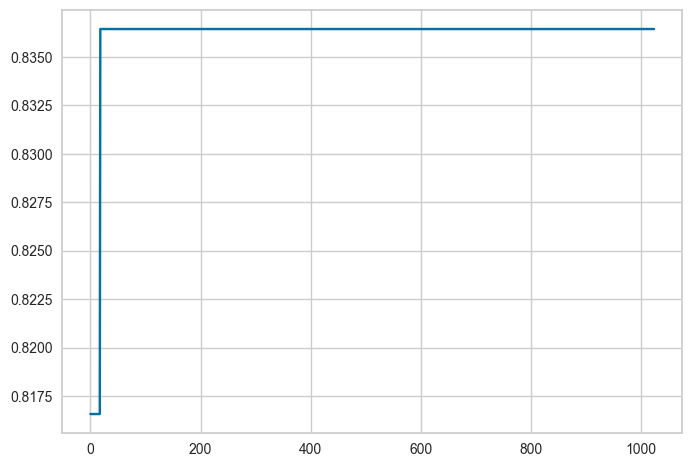

In [415]:
plt.plot(Accuracy_PSO);

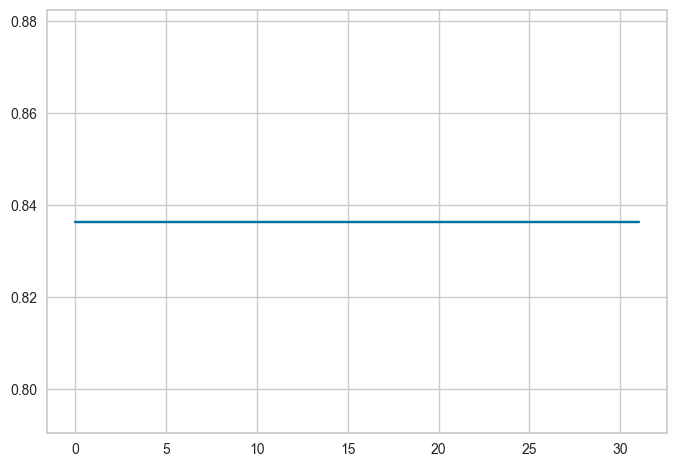

In [416]:
tracking = [-np.min(individual.pop.get('F')) for individual in res.history ]
tracking_PSO_Accuracy = tracking
plt.plot(tracking)

### F1 Score 

In [417]:
def run_f1_pso(ITERATIONS = 32, POPULATION = 32):
    algorithm = PSO(#pop_size=POPULATION, 
                    #w=0.3, c1=4.0, c2=1.0, 
                    #adaptive=False, initial_velocity='random', 
                    #max_velocity_rate=0.75, pertube_best=False,
                    max_velocity_rate=0.25,
                    pop_size=POPULATION)
    term = get_termination("n_gen", ITERATIONS)

    res = minimize(problemF1,
                algorithm,
                #seed=SEED,
                save_history=True,
                verbose=False,
                output=MyOutput(),
                termination = term)


    index_best_individual = np.where(res.pop.get('F') == np.min(res.pop.get('F')))[0][0]
    score_best_individual = res.pop.get('F')[index_best_individual]
    parameters_best_individual = res.pop.get('X')[index_best_individual]

    print(f'Best F1 Score {-score_best_individual}')
    print(f'Model parameters: \n {parameters_best_individual}')
    return score_best_individual, parameters_best_individual, res

In [418]:
score_best_individual, parameters_best_individual, res = run_f1_pso()

C:\Users\Felps\AppData\Local\Temp\ipykernel_25136\3063938903.py:8: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


  0%|          | 0/32 [00:00<?, ?it/s]

Best F1 Score [0.86970108]
Model parameters: 
 [9.99312519e+01 1.47438235e+01 2.14097078e+02 4.82676074e-01
 3.47820857e+05 6.82594321e-02 4.18271143e-02 7.24518708e+00
 1.94193774e+01 7.09766479e+00 1.96417814e-01 8.46723773e-01
 4.19048964e-01 6.48278433e+01 4.93626574e-02 8.04805808e-01
 7.15340668e-01 2.55582784e+00 5.27624836e+00 3.98142819e+01
 4.82015394e+01 6.98698604e+00 1.45221922e+01 1.94099952e+01
 3.25461900e+01]


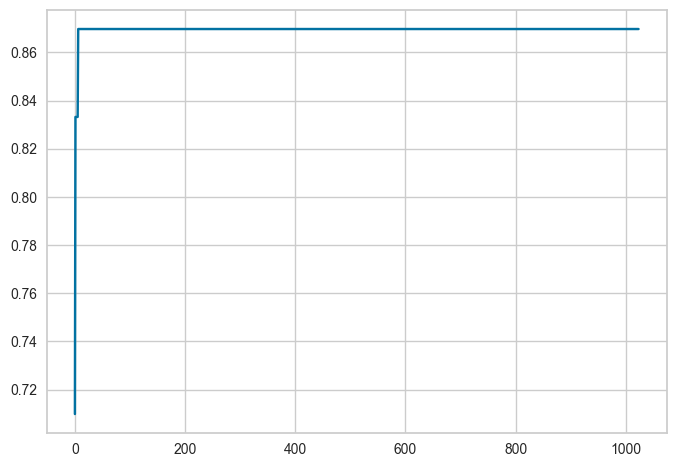

In [419]:
trlist = np.array([])
for i in range(len(res.history)):
  trlist = np.append(trlist, -res.history[i].pop.get('F').reshape(-1)) 
  
scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])
    
F1_PSO = scorelist

plt.plot(scorelist);

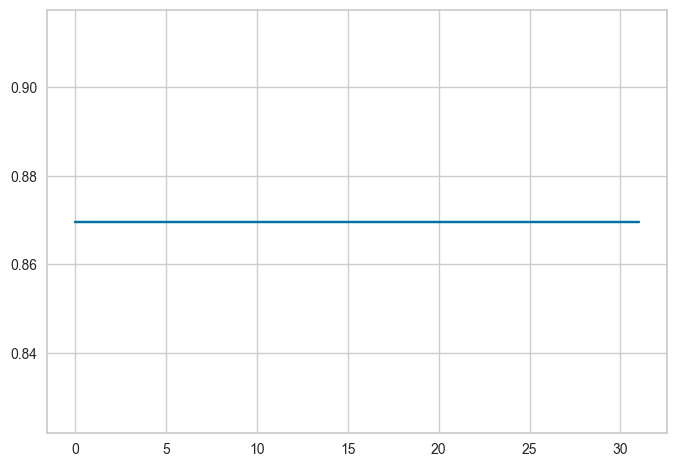

In [420]:
tracking = [-np.min(individual.pop.get('F')) for individual in res.history ]
tracking_PSO_F1 = tracking
plt.plot(tracking)

### AUC

In [421]:
def run_auc_pso(ITERATIONS = 32, POPULATION = 32):
    algorithm = PSO(#pop_size=POPULATION, 
                    #w=0.3, c1=4.0, c2=1.0, 
                    #adaptive=False, initial_velocity='random', 
                    #max_velocity_rate=0.75, pertube_best=False,
                    max_velocity_rate=0.25,
                    pop_size=POPULATION)
    term = get_termination("n_gen", ITERATIONS)

    res = minimize(problemAUC,
                algorithm,
                #seed=SEED,
                save_history=True,
                verbose=False,
                output=MyOutput(),
                termination = term)


    index_best_individual = np.where(res.pop.get('F') == np.min(res.pop.get('F')))[0][0]
    score_best_individual = res.pop.get('F')[index_best_individual]
    parameters_best_individual = res.pop.get('X')[index_best_individual]

    print(f'Best AUC Score {-score_best_individual}')
    print(f'Model parameters: \n {parameters_best_individual}')
    
    return score_best_individual, parameters_best_individual, res

In [422]:
score_best_individual, parameters_best_individual, res = run_auc_pso()

C:\Users\Felps\AppData\Local\Temp\ipykernel_25136\2789063471.py:8: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


  0%|          | 0/32 [00:00<?, ?it/s]

Best AUC Score [0.92449963]
Model parameters: 
 [ 4.73813945e+01  4.55087609e+01  1.36494038e+02  1.01274885e-01
  4.06151955e+05  1.76887851e-01  7.22206203e-02  1.06242648e+00
  1.27784251e+01  8.28748097e+00  1.39336696e-01  6.71149742e-01
  6.91888612e-01  5.04029667e+01  8.04766353e-01  3.65388918e-02
  5.06235654e-01 -4.89750296e+00  7.56073038e-01  9.80359595e+01
  6.12079004e+01  1.92405959e+01  1.19180935e+01  1.97957998e+01
  2.24628576e+01]


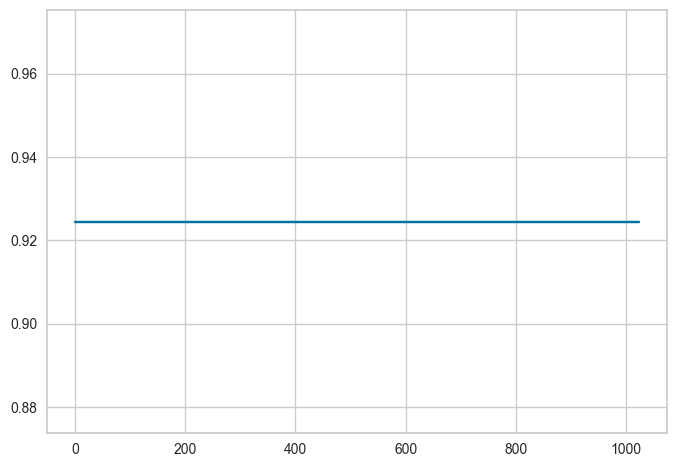

In [423]:
trlist = np.array([])
for i in range(len(res.history)):
  trlist = np.append(trlist, -res.history[i].pop.get('F').reshape(-1)) 
  
scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])
    
AUC_PSO = scorelist

plt.plot(scorelist);

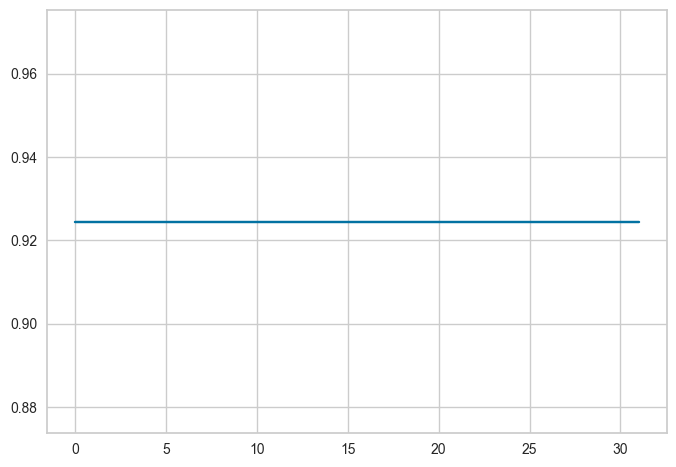

In [424]:
tracking = [-np.min(individual.pop.get('F')) for individual in res.history ]
tracking_PSO_AUC = tracking
plt.plot(tracking)

## Algoritmo Genético (GA)

### Acurácia

In [425]:
ITERATIONS = 32
POPULATION = 32

In [426]:
from pymoo.algorithms.soo.nonconvex.ga import GA

In [427]:
def run_accuracy_ga(ITERATIONS = 32, POPULATION = 32):

    algorithm = GA(pop_size=POPULATION)

    term = get_termination("n_gen", ITERATIONS)

    res = minimize(problemAccuracy,
                algorithm,
                save_history=True,
                verbose=False,
                output=MyOutput(),
                termination = term)


    index_best_individual = np.where(res.pop.get('F') == np.min(res.pop.get('F')))[0][0]
    score_best_individual = res.pop.get('F')[index_best_individual]
    parameters_best_individual = res.pop.get('X')[index_best_individual]

    print(f'Best Accuracy Score {-score_best_individual}')
    print(f'Model parameters: \n {parameters_best_individual}')
    
    return score_best_individual, parameters_best_individual, res

In [428]:
score_best_individual, parameters_best_individual, res = run_accuracy_ga()

C:\Users\Felps\AppData\Local\Temp\ipykernel_25136\2052111469.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


  0%|          | 0/32 [00:00<?, ?it/s]

Best Accuracy Score [0.88948171]
Model parameters: 
 [1.35153620e+02 4.77507182e+01 8.95268808e+02 2.88402403e-01
 3.32469022e+05 2.03167703e-02 1.19431132e-01 2.45300171e+00
 1.60752828e+01 4.49476707e+01 5.18245806e-01 9.18974355e-01
 9.29301708e-01 5.47238011e+01 7.15977973e-01 4.33173420e-01
 6.88256495e-01 6.87734729e+00 9.44210330e+00 1.66500470e+02
 9.51976075e+01 1.68393714e+01 8.50048900e+00 1.18736639e+01
 2.02545673e+01]


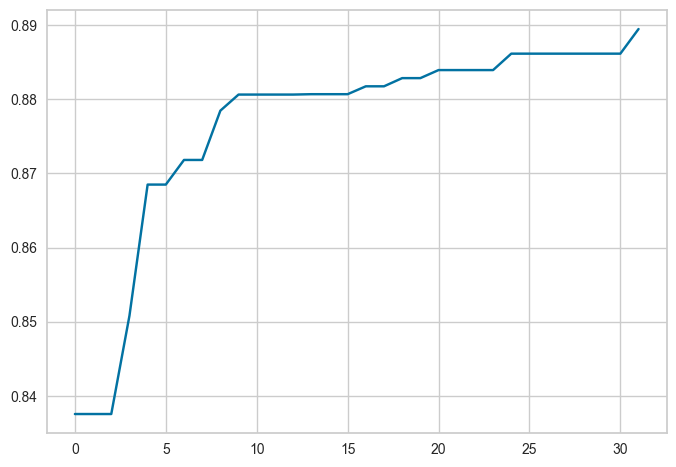

In [429]:
tracking = [-np.min(individual.pop.get('F')) for individual in res.history ]
tracking_GA_Accuracy = tracking
plt.plot(tracking)

In [430]:
trlist = np.array([])
for i in range(len(res.history)):
  trlist = np.append(trlist, -res.history[i].pop.get('F').reshape(-1)) 

In [431]:
scorelist = []

for i in range(len(trlist)):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])

In [432]:
Accuracy_GA = scorelist

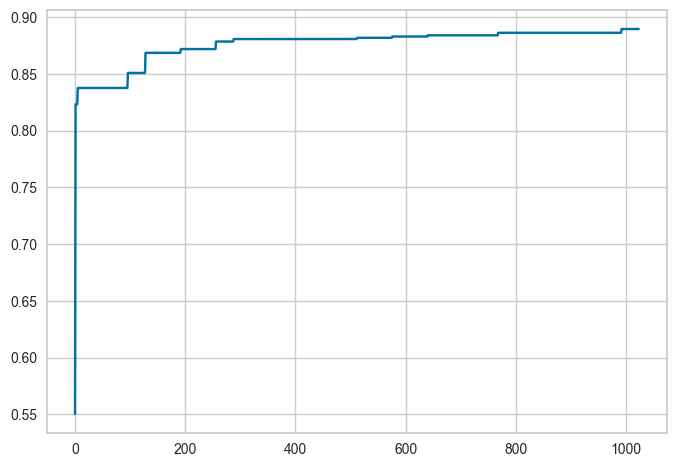

In [433]:
plt.plot(scorelist);

### F1 Score 

In [434]:
from pymoo.algorithms.soo.nonconvex.ga import GA
def run_f1_ga(ITERATIONS = 32, POPULATION = 32):
    algorithm = GA(pop_size=POPULATION)

    term = get_termination("n_gen", ITERATIONS)

    res = minimize(problemF1,
                algorithm,
                save_history=True,
                verbose=False,
                output=MyOutput(),
                termination = term)


    index_best_individual = np.where(res.pop.get('F') == np.min(res.pop.get('F')))[0][0]
    score_best_individual = res.pop.get('F')[index_best_individual]
    parameters_best_individual = res.pop.get('X')[index_best_individual]

    print(f'Best F1 Score {-score_best_individual}')
    print(f'Model parameters: \n {parameters_best_individual}')
    
    return score_best_individual, parameters_best_individual, res

In [435]:
score_best_individual, parameters_best_individual, res = run_f1_ga()

C:\Users\Felps\AppData\Local\Temp\ipykernel_25136\1091602741.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


  0%|          | 0/32 [00:00<?, ?it/s]

Best F1 Score [0.90191073]
Model parameters: 
 [ 6.80110066e+01  1.53812212e+01  3.47818059e+02  1.00099215e-01
  2.08437402e+05  1.79821641e-01  2.78240523e-02  9.45184991e-01
  1.03119749e+00  1.51897718e+01  2.76769437e-02  8.93062613e-01
  7.11004340e-01  5.39886922e+01  3.43759092e-01  1.13154533e-01
  6.60831772e-03 -5.94202830e-01  6.50444879e+00  8.74242339e+01
  6.44491677e+01  5.08213676e-01  6.85889477e+00  1.35547847e+01
  1.66390452e+00]


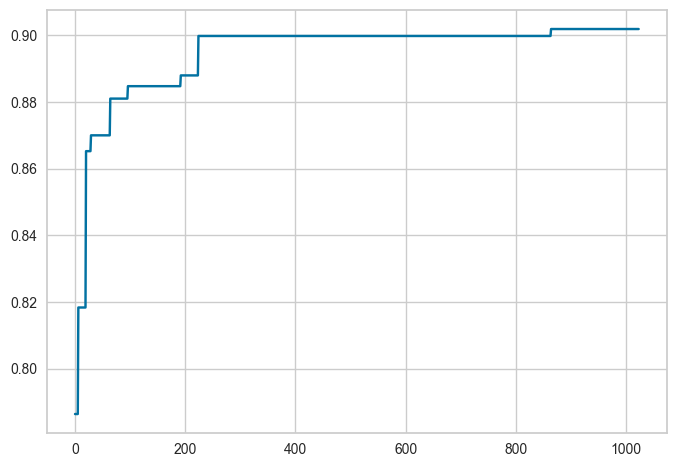

In [436]:
trlist = np.array([])
for i in range(len(res.history)):
  trlist = np.append(trlist, -res.history[i].pop.get('F').reshape(-1)) 
  
scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])
    
F1_GA = scorelist

plt.plot(scorelist);

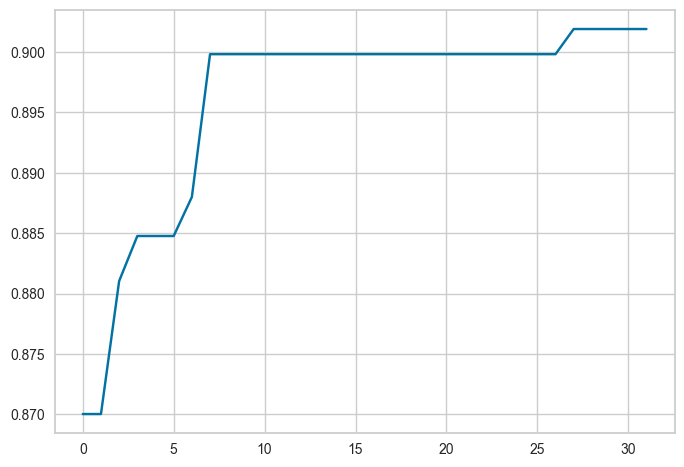

In [437]:
tracking = [-np.min(individual.pop.get('F')) for individual in res.history ]
tracking_GA_F1 = tracking
plt.plot(tracking)

### AUC

In [438]:
from pymoo.algorithms.soo.nonconvex.ga import GA
def run_auc_ga(ITERATIONS = 32, POPULATION = 32):
    algorithm = GA(pop_size=POPULATION)

    term = get_termination("n_gen", ITERATIONS)

    res = minimize(problemAUC,
                algorithm,
                save_history=True,
                verbose=False,
                output=MyOutput(),
                termination = term)


    index_best_individual = np.where(res.pop.get('F') == np.min(res.pop.get('F')))[0][0]
    score_best_individual = res.pop.get('F')[index_best_individual]
    parameters_best_individual = res.pop.get('X')[index_best_individual]

    print(f'Best AUC Score {-score_best_individual}')
    print(f'Model parameters: \n {parameters_best_individual}')
    
    return score_best_individual, parameters_best_individual, res

In [439]:
score_best_individual, parameters_best_individual, res = run_auc_ga()

C:\Users\Felps\AppData\Local\Temp\ipykernel_25136\2997799980.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


  0%|          | 0/32 [00:00<?, ?it/s]

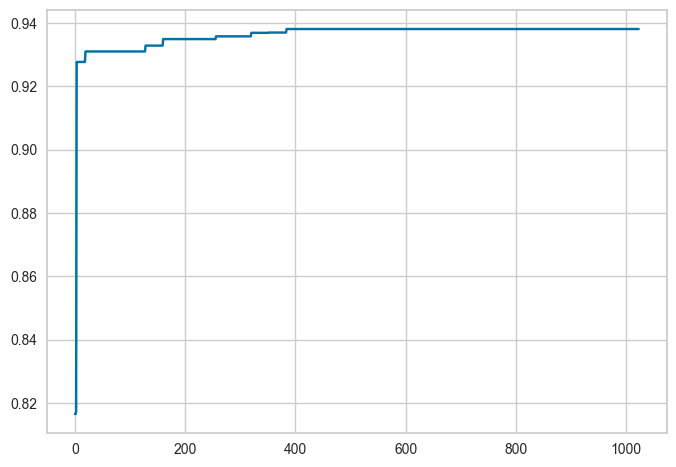

In [ ]:
trlist = np.array([])
for i in range(len(res.history)):
  trlist = np.append(trlist, -res.history[i].pop.get('F').reshape(-1)) 
  
scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])
    
AUC_GA = scorelist

plt.plot(scorelist);

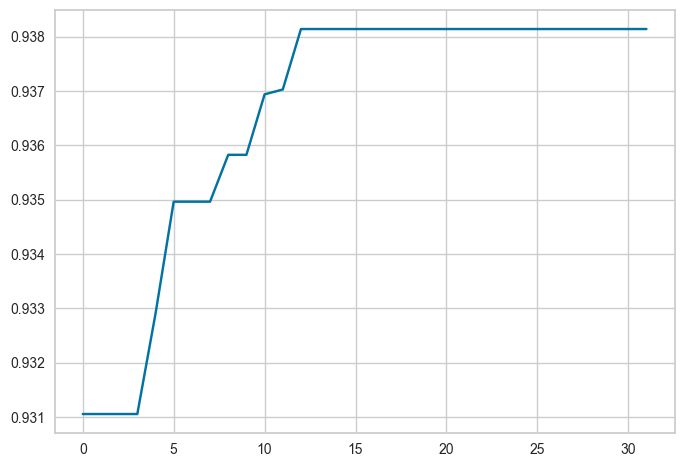

In [ ]:
tracking = [-np.min(individual.pop.get('F')) for individual in res.history ]
tracking_GA_AUC = tracking
plt.plot(tracking)

## Grid Search

### Acurácia

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
n_possibilities = 2

#num_leaves_grid = [i for i in range(num_leaves_min,num_leaves_max, int((num_leaves_max)/13))]
num_leaves_grid = [i for i in map(lambda x: int(x), np.linspace(num_leaves_min, num_leaves_max, n_possibilities))]
num_leaves_grid = num_leaves_grid + [100, 50, 75, 125, 11,150]
print('Num_Leaves_Grid: ')
print(num_leaves_grid, len(num_leaves_grid))
print('\n')


min_child_samples_grid = [i for i in map(lambda x: int(x), np.linspace(min_child_samples_min, min_child_samples_max, n_possibilities))]
print('min_child_samples_grid:')
print(min_child_samples_grid, len(min_child_samples_grid))
print('\n')

n_estimators_grid = [i for i in map(lambda x: int(x), np.linspace(n_estimators_min, n_estimators_max, n_possibilities))]
print('n_estimators_grid:')
print(n_estimators_grid, len(n_estimators_grid))
print('\n')

learning_rate_grid = np.linspace(learning_rate_min, learning_rate_max, n_possibilities)
print('learning_rate_grid:')
print(learning_rate_grid, len(learning_rate_grid))
print('\n')

subsample_for_bin_grid = [i for i in map(lambda x: int(x), np.linspace(subsample_for_bin_min, subsample_for_bin_max, n_possibilities))]
print('subsample_for_bin_grid:')
print(subsample_for_bin_grid, len(subsample_for_bin_grid))
print('\n')

min_split_gain_grid = np.linspace(min_split_gain_min, min_split_gain_max, n_possibilities)
print('min_split_gain_grid:')
print(min_split_gain_grid, len(min_split_gain_grid))
print('\n')

min_child_weight_grid = np.linspace(min_child_weight_min, min_child_weight_max, n_possibilities)
print('min_child_weight_grid:')
print(min_child_weight_grid, len(min_child_weight_grid))
print('\n')

reg_alpha_grid = np.linspace(reg_alpha_min, reg_alpha_max, n_possibilities)
print('reg_alpha_grid:')
print(reg_alpha_grid, len(reg_alpha_grid))
print('\n')


Num_Leaves_Grid: 
[10, 200, 100, 50, 75, 125, 11, 150] 8


min_child_samples_grid:
[10, 50] 2


n_estimators_grid:
[20, 1000] 2


learning_rate_grid:
[0.001 0.5  ] 2


subsample_for_bin_grid:
[50000, 500000] 2


min_split_gain_grid:
[0.01 0.5 ] 2


min_child_weight_grid:
[0.001 0.15 ] 2


reg_alpha_grid:
[1.e-02 1.e+02] 2




In [ ]:
parametros = {'num_leaves': num_leaves_grid, #int
              'min_child_samples': min_child_samples_grid,#int
              'n_estimators': n_estimators_grid, #int
              'learning_rate': learning_rate_grid,
              'subsample_for_bin': subsample_for_bin_grid, # int
              'min_split_gain': min_split_gain_grid,
              'min_child_weight': min_child_weight_grid,
              'reg_alpha': reg_alpha_grid,
              'max_depth': [-1],
              'n_jobs': [-1]}

In [ ]:
kfold = KFold(n_splits = 3, shuffle = True)
grid_search = GridSearchCV(estimator = lgb.LGBMClassifier(), param_grid = parametros, cv = kfold, n_jobs= -1, verbose = 3)
grid_search.fit(x_heart, y_heart)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

Fitting 3 folds for each of 1024 candidates, totalling 3072 fits
{'learning_rate': 0.5, 'max_depth': -1, 'min_child_samples': 50, 'min_child_weight': 0.001, 'min_split_gain': 0.01, 'n_estimators': 20, 'n_jobs': -1, 'num_leaves': 200, 'reg_alpha': 0.01, 'subsample_for_bin': 50000}
0.8651661496263375


In [ ]:
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_rate', 'param_max_depth', 'param_min_child_samples', 'param_min_child_weight', 'param_min_split_gain', 'param_n_estimators', 'param_n_jobs', 'param_num_leaves', 'param_reg_alpha', 'param_subsample_for_bin', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [ ]:
trlist = grid_search.cv_results_['mean_test_score']

In [ ]:
scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])

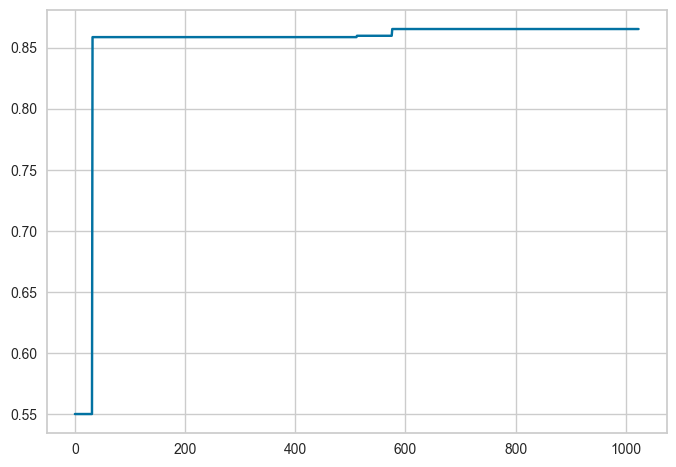

In [ ]:
tracking_GS_Accuracy = scorelist
plt.plot(scorelist); 

### F1 Score

Fitting 3 folds for each of 1024 candidates, totalling 3072 fits
{'learning_rate': 0.5, 'max_depth': -1, 'min_child_samples': 10, 'min_child_weight': 0.001, 'min_split_gain': 0.5, 'n_estimators': 20, 'n_jobs': -1, 'num_leaves': 11, 'reg_alpha': 0.01, 'subsample_for_bin': 50000}
0.8829566318455209


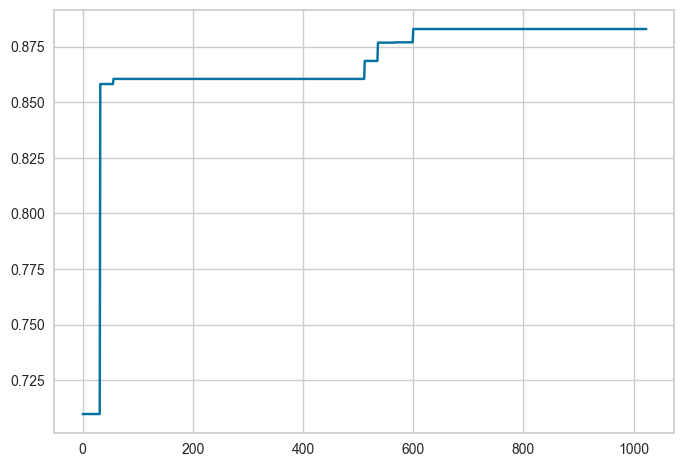

In [ ]:
kfold = KFold(n_splits = 3, shuffle = True)
grid_search = GridSearchCV(estimator = lgb.LGBMClassifier(), param_grid = parametros, cv = kfold, n_jobs= -1, scoring='f1', verbose = 3)
grid_search.fit(x_heart, y_heart)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

trlist = grid_search.cv_results_['mean_test_score']


scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])
    
tracking_GS_F1 = scorelist
plt.plot(scorelist); 

### AUC

Fitting 3 folds for each of 1024 candidates, totalling 3072 fits
{'learning_rate': 0.5, 'max_depth': -1, 'min_child_samples': 50, 'min_child_weight': 0.001, 'min_split_gain': 0.5, 'n_estimators': 20, 'n_jobs': -1, 'num_leaves': 10, 'reg_alpha': 0.01, 'subsample_for_bin': 50000}
0.9314946113809567


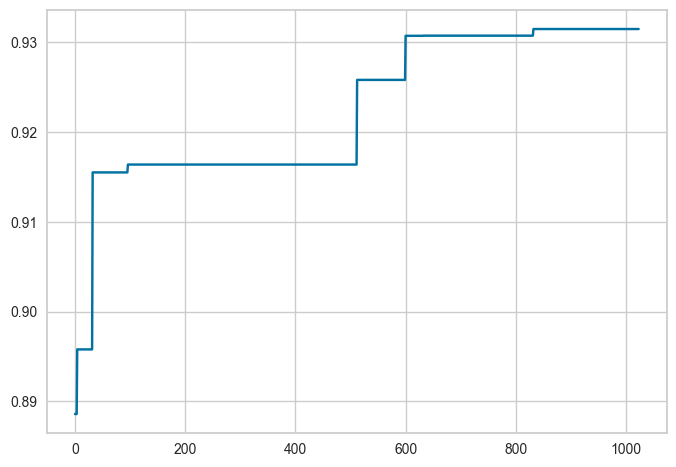

In [ ]:
kfold = KFold(n_splits = 3, shuffle = True)
grid_search = GridSearchCV(estimator = lgb.LGBMClassifier(), param_grid = parametros, cv = kfold, n_jobs= -1, scoring='roc_auc', verbose = 3)
grid_search.fit(x_heart, y_heart)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

trlist = grid_search.cv_results_['mean_test_score']


scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])
    
tracking_GS_AUC = scorelist
plt.plot(scorelist); 

## Optuna

### Acurácia

In [ ]:
!pip install optuna

In [ ]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import sklearn
from sklearn import datasets
def objective_accuracy(trial):
  
      num_leaves = trial.suggest_int('num_leaves', num_leaves_min, num_leaves_max) #int
      min_child_samples = trial.suggest_int('min_child_samples', min_child_samples_min, min_child_samples_max) #int
      n_estimators      = trial.suggest_int('n_estimators', n_estimators_min, n_estimators_max)#int
      learning_rate     = trial.suggest_float('learning_rate', learning_rate_min, learning_rate_max)
      subsample_for_bin = trial.suggest_int('subsample_for_bin', subsample_for_bin_min, subsample_for_bin_max) #int
      min_split_gain    = trial.suggest_float('min_split_gain', min_split_gain_min, min_split_gain_max)
      min_child_weight  = trial.suggest_float('min_child_weight', min_child_weight_min, min_child_weight_max)
      reg_alpha         = trial.suggest_float('reg_alpha', reg_alpha_min, reg_alpha_max)
      reg_lambda        = trial.suggest_float('reg_lambda', reg_lambda_min, reg_lambda_max)

      final_model = lgb.LGBMClassifier(num_leaves       = num_leaves, 
                                      min_child_samples = min_child_samples, 
                                      n_estimators      = n_estimators,
                                      learning_rate     = learning_rate,
                                      subsample_for_bin = subsample_for_bin,
                                      min_split_gain    = min_split_gain,
                                      min_child_weight  = min_child_weight,
                                      reg_alpha         = reg_alpha,
                                      reg_lambda        = reg_lambda,
                                      max_depth= -1,
                                      n_jobs = -1
                                      )
      
      kfold = KFold(n_splits = 3, shuffle = True)

      return sklearn.model_selection.cross_val_score(final_model, x_heart, y_heart, n_jobs=-1, cv=kfold).mean()

In [ ]:
def run_optuna_accuracy(n_trials=1024):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_accuracy, n_trials=n_trials, n_jobs = -1)
    trial = study.best_trial
    print('Accuracy: {}'.format(trial.value))
    print("Best hyperparameters: {}".format(trial.params))
    return trial.value, study


In [ ]:
trial, study = run_optuna_accuracy()

Accuracy: 0.8828848650194715
Best hyperparameters: {'num_leaves': 71, 'min_child_samples': 31, 'n_estimators': 375, 'learning_rate': 0.0819443200712924, 'subsample_for_bin': 375667, 'min_split_gain': 0.13955503501411679, 'min_child_weight': 0.10159705861183119, 'reg_alpha': 0.4010413521901146, 'reg_lambda': 5.930561785599831}


In [ ]:
trial

0.8828848650194715

In [ ]:
tracking = []
for i in range(len(study.trials)):
  if i == 0: 
    tracking.append(study.trials[i].value)
  elif tracking[i-1] > study.trials[i].value:
    tracking.append(tracking[i-1])
  else:
    tracking.append(study.trials[i].value)
#tracking_sorted = sorted(tracking)

In [ ]:
tracking_Optuna_Accuracy = tracking

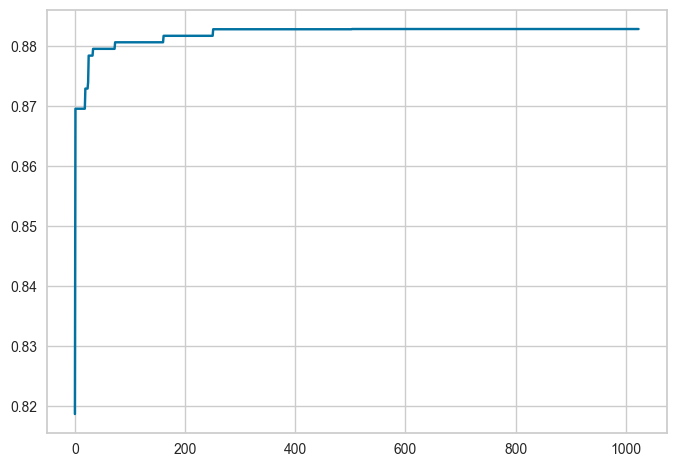

In [ ]:
plt.plot(tracking);
#plt.plot(tracking_sorted) 

In [ ]:
#optuna.visualization.plot_optimization_history(study)

In [ ]:
#optuna.visualization.plot_slice(study)

### F1 Score

In [ ]:
def objective_f1(trial):
  
      num_leaves = trial.suggest_int('num_leaves', num_leaves_min, num_leaves_max) #int
      min_child_samples = trial.suggest_int('min_child_samples', min_child_samples_min, min_child_samples_max) #int
      n_estimators      = trial.suggest_int('n_estimators', n_estimators_min, n_estimators_max)#int
      learning_rate     = trial.suggest_float('learning_rate', learning_rate_min, learning_rate_max)
      subsample_for_bin = trial.suggest_int('subsample_for_bin', subsample_for_bin_min, subsample_for_bin_max) #int
      min_split_gain    = trial.suggest_float('min_split_gain', min_split_gain_min, min_split_gain_max)
      min_child_weight  = trial.suggest_float('min_child_weight', min_child_weight_min, min_child_weight_max)
      reg_alpha         = trial.suggest_float('reg_alpha', reg_alpha_min, reg_alpha_max)
      reg_lambda        = trial.suggest_float('reg_lambda', reg_lambda_min, reg_lambda_max)

      final_model = lgb.LGBMClassifier(num_leaves       = num_leaves, 
                                      min_child_samples = min_child_samples, 
                                      n_estimators      = n_estimators,
                                      learning_rate     = learning_rate,
                                      subsample_for_bin = subsample_for_bin,
                                      min_split_gain    = min_split_gain,
                                      min_child_weight  = min_child_weight,
                                      reg_alpha         = reg_alpha,
                                      reg_lambda        = reg_lambda,
                                      max_depth= -1,
                                      n_jobs = -1
                                      )
      
      kfold = KFold(n_splits = 3, shuffle = True)

      return sklearn.model_selection.cross_val_score(final_model, x_heart, y_heart, n_jobs=-1, scoring='f1', cv=kfold).mean()

In [ ]:
def run_optuna_f1(n_trials=1024):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_f1, n_trials=n_trials, n_jobs = -1)
    trial = study.best_trial
    print('F1: {}'.format(trial.value))
    print("Best hyperparameters: {}".format(trial.params))
    return trial.value, study

In [ ]:
trial, study = run_optuna_f1()

F1: 0.8964084397834937
Best hyperparameters: {'num_leaves': 10, 'min_child_samples': 15, 'n_estimators': 701, 'learning_rate': 0.06831995105029873, 'subsample_for_bin': 90980, 'min_split_gain': 0.05930755077458183, 'min_child_weight': 0.11305470211633926, 'reg_alpha': 1.684306299649191, 'reg_lambda': 25.901144348107817}


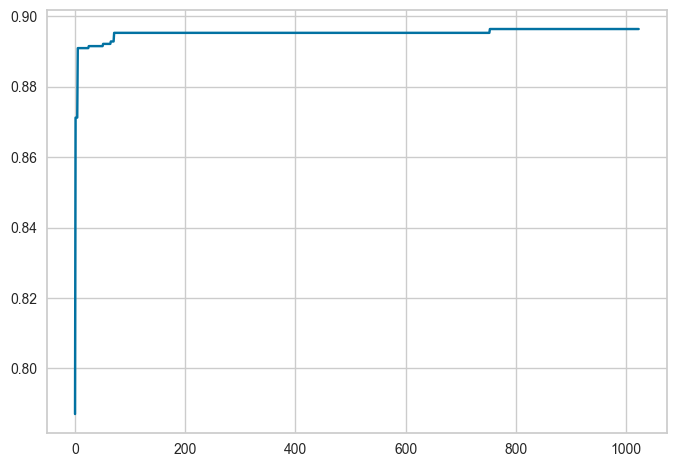

In [ ]:
tracking = []
for i in range(len(study.trials)):
  if i == 0: 
    tracking.append(study.trials[i].value)
  elif tracking[i-1] > study.trials[i].value:
    tracking.append(tracking[i-1])
  else:
    tracking.append(study.trials[i].value)
#tracking_sorted = sorted(tracking)

tracking_Optuna_F1 = tracking

plt.plot(tracking);
#plt.plot(tracking_sorted) 

### AUC

In [ ]:
def objective_auc(trial):
  
      num_leaves = trial.suggest_int('num_leaves', num_leaves_min, num_leaves_max) #int
      min_child_samples = trial.suggest_int('min_child_samples', min_child_samples_min, min_child_samples_max) #int
      n_estimators      = trial.suggest_int('n_estimators', n_estimators_min, n_estimators_max)#int
      learning_rate     = trial.suggest_float('learning_rate', learning_rate_min, learning_rate_max)
      subsample_for_bin = trial.suggest_int('subsample_for_bin', subsample_for_bin_min, subsample_for_bin_max) #int
      min_split_gain    = trial.suggest_float('min_split_gain', min_split_gain_min, min_split_gain_max)
      min_child_weight  = trial.suggest_float('min_child_weight', min_child_weight_min, min_child_weight_max)
      reg_alpha         = trial.suggest_float('reg_alpha', reg_alpha_min, reg_alpha_max)
      reg_lambda        = trial.suggest_float('reg_lambda', reg_lambda_min, reg_lambda_max)

      final_model = lgb.LGBMClassifier(num_leaves       = num_leaves, 
                                      min_child_samples = min_child_samples, 
                                      n_estimators      = n_estimators,
                                      learning_rate     = learning_rate,
                                      subsample_for_bin = subsample_for_bin,
                                      min_split_gain    = min_split_gain,
                                      min_child_weight  = min_child_weight,
                                      reg_alpha         = reg_alpha,
                                      reg_lambda        = reg_lambda,
                                      max_depth= -1,
                                      n_jobs = -1
                                      )
      
      kfold = KFold(n_splits = 3, shuffle = True)

      return sklearn.model_selection.cross_val_score(final_model, x_heart, y_heart, n_jobs=-1, scoring='roc_auc', cv=kfold).mean()

In [ ]:
def run_optuna_auc(n_trials=1024):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_auc, n_trials=n_trials, n_jobs = -1)
    trial = study.best_trial
    print('AUC: {}'.format(trial.value))
    print("Best hyperparameters: {}".format(trial.params))
    return trial.value, study

In [ ]:
trial, study = run_optuna_auc()

AUC: 0.9383541621185482
Best hyperparameters: {'num_leaves': 134, 'min_child_samples': 49, 'n_estimators': 203, 'learning_rate': 0.40228213466276985, 'subsample_for_bin': 314312, 'min_split_gain': 0.14539405228844365, 'min_child_weight': 0.09563654717509301, 'reg_alpha': 0.03374330342697546, 'reg_lambda': 64.30929855392117}


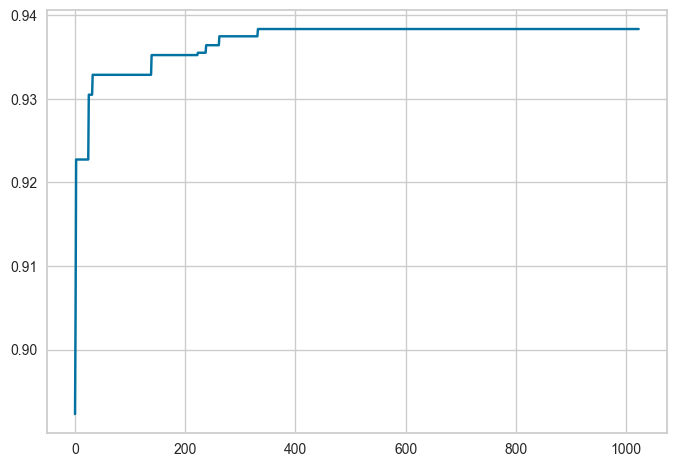

In [ ]:
tracking = []
for i in range(len(study.trials)):
  if i == 0: 
    tracking.append(study.trials[i].value)
  elif tracking[i-1] > study.trials[i].value:
    tracking.append(tracking[i-1])
  else:
    tracking.append(study.trials[i].value)
#tracking_sorted = sorted(tracking)

tracking_Optuna_AUC = tracking

plt.plot(tracking);
#plt.plot(tracking_sorted) 

# Análise Comparativa

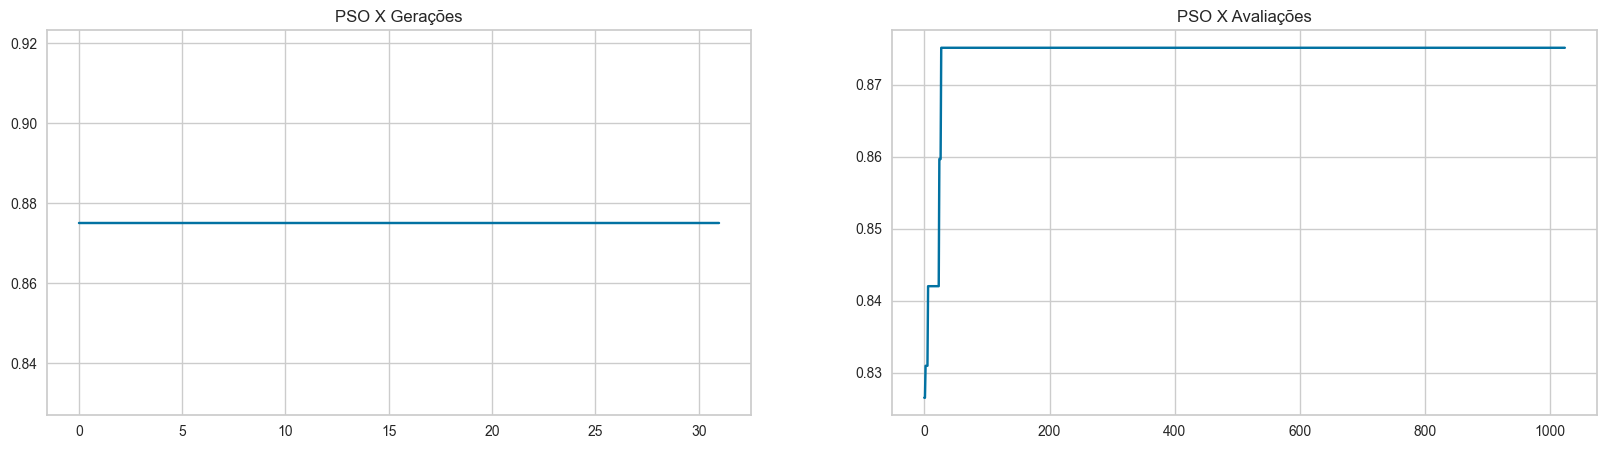

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax1.set_title('PSO X Gerações')
ax2.set_title('PSO X Avaliações')

ax1.plot(tracking_PSO_Accuracy)
ax2.plot(Accuracy_PSO)
plt.show()

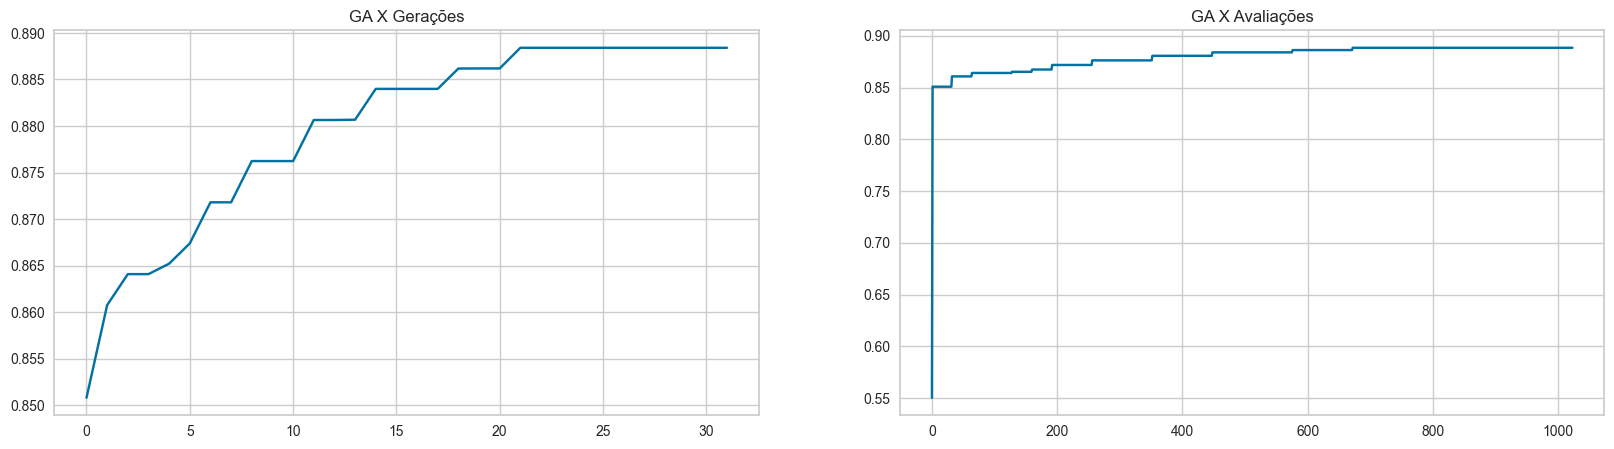

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax1.set_title('GA X Gerações')
ax2.set_title('GA X Avaliações')

ax1.plot(tracking_GA_Accuracy)
ax2.plot(Accuracy_GA)
plt.show()

Gráficos Comparativos Acurácia

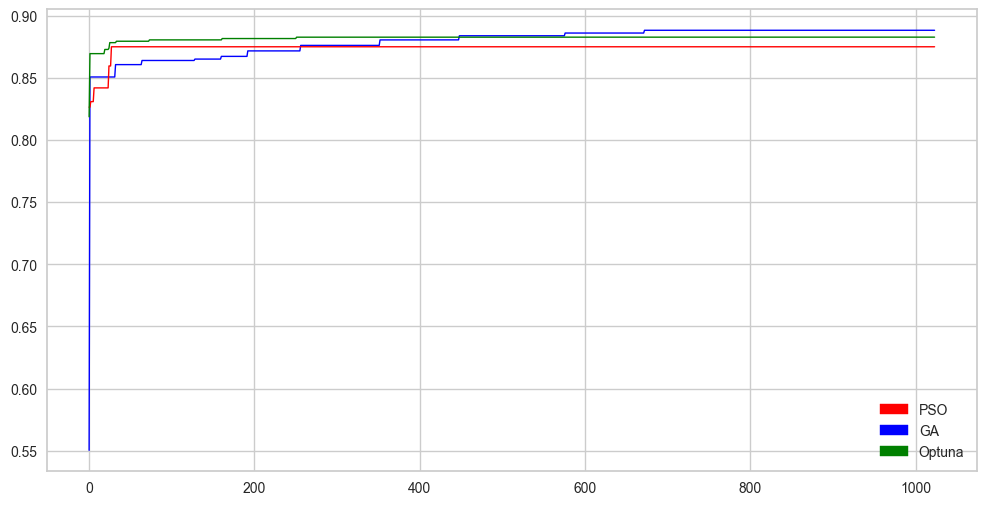

In [ ]:
from IPython.core.pylabtools import figsize
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

plt.figure(figsize=(12, 6))
red_patch = mpatches.Patch(color='red', label='PSO')
blue_patch = mpatches.Patch(color='blue', label='GA')
green_patch = mpatches.Patch(color='green', label='Optuna')
#black_patch = mpatches.Patch(color='black', label='GridSearch')

plt.legend(handles=[red_patch, blue_patch, green_patch])
plt.plot(Accuracy_GA, color = 'blue', linewidth=1, linestyle='-', )
plt.plot(Accuracy_PSO, color = 'red', linewidth=1, linestyle='-')
plt.plot(tracking_Optuna_Accuracy, color = 'green', linewidth=1, linestyle='-')
#plt.plot(tracking_GS, color = 'black', linewidth=3, linestyle='-')
plt.show()

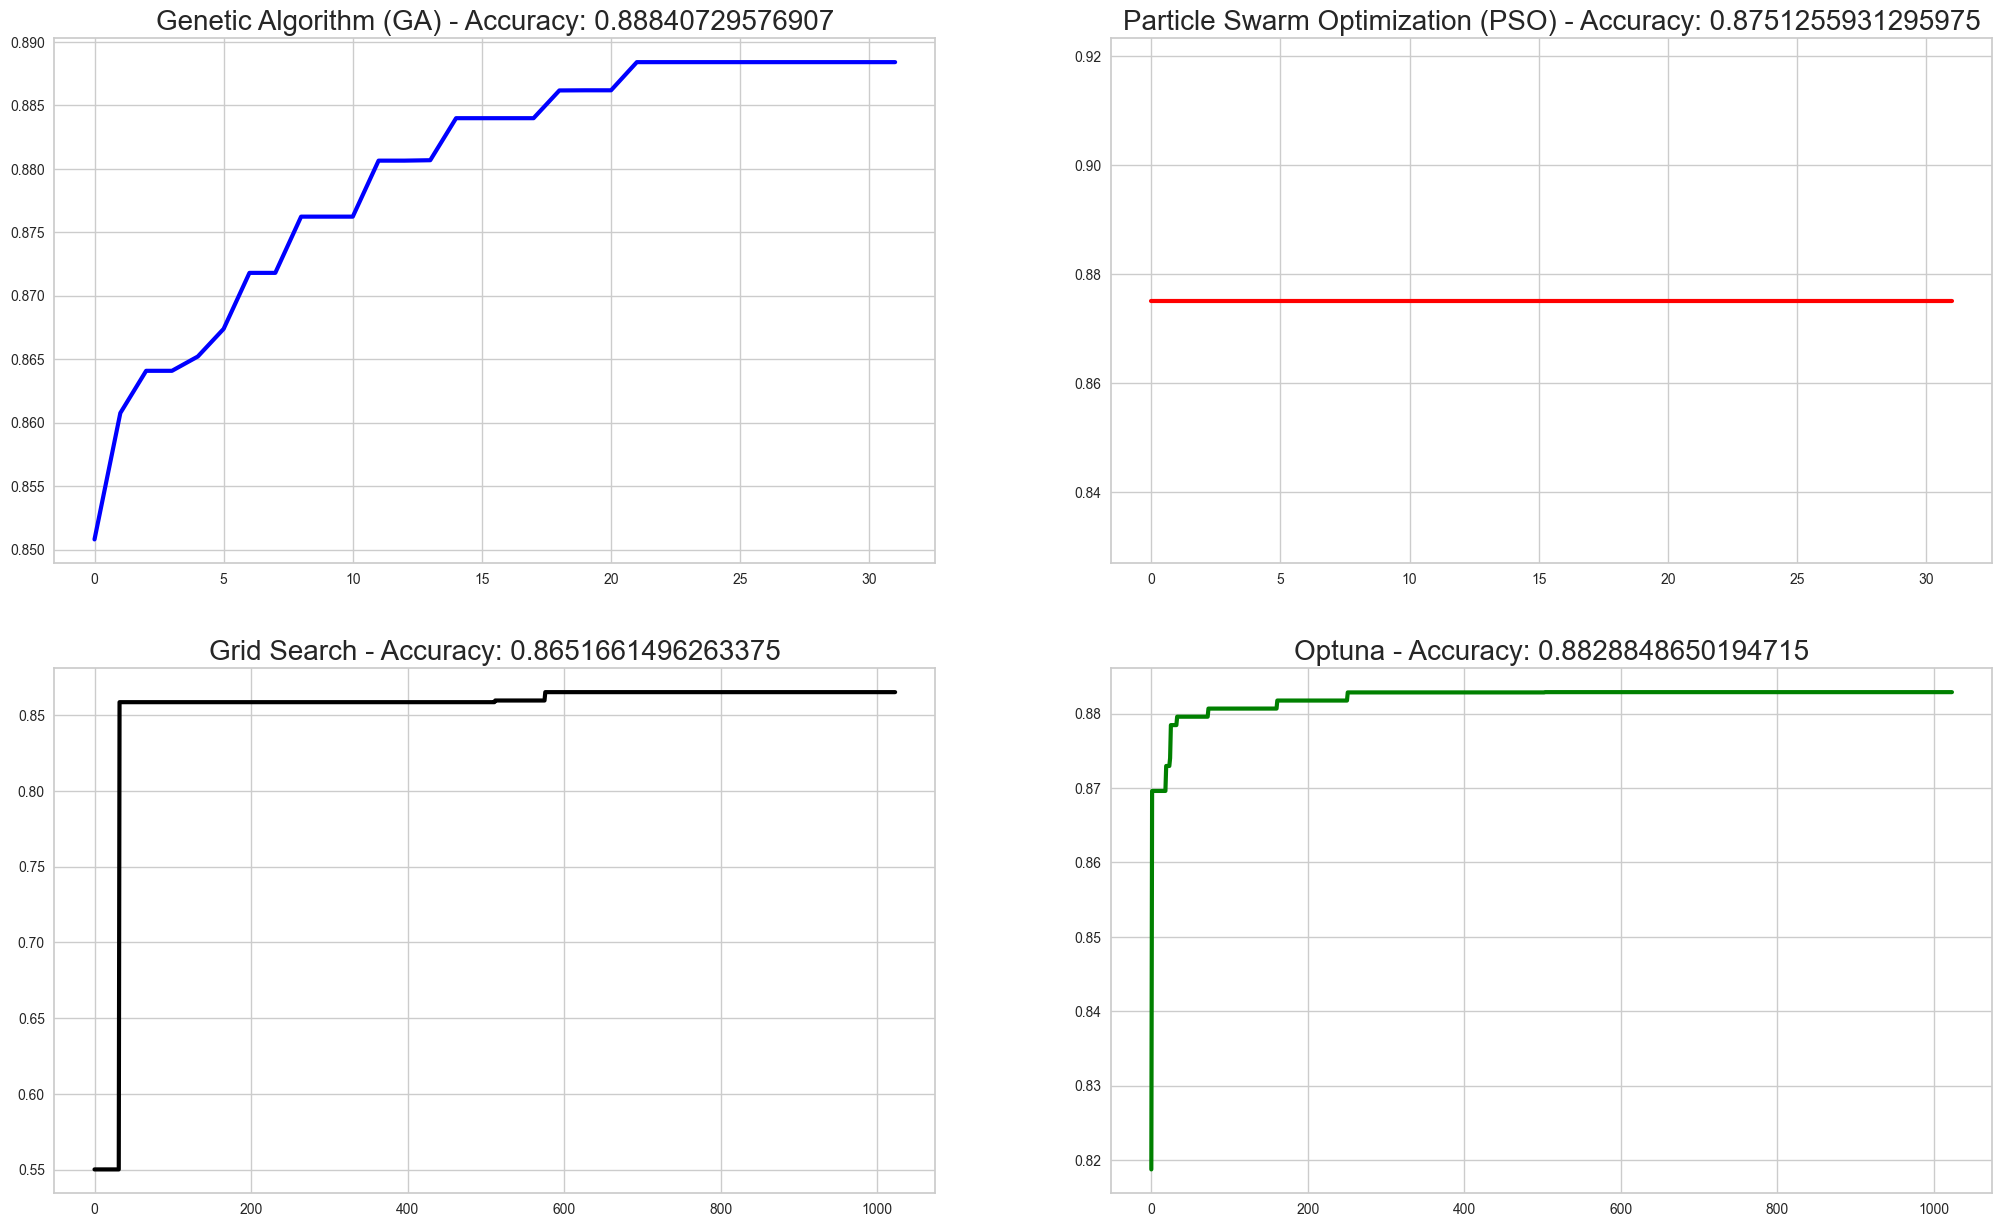

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(25,15))

ax[0, 0].set_title(f'Genetic Algorithm (GA) - Accuracy: {max(tracking_GA_Accuracy)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax[0, 1].set_title(f'Particle Swarm Optimization (PSO) - Accuracy: {max(tracking_PSO_Accuracy)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax[1, 0].set_title(f'Grid Search - Accuracy: {max(tracking_GS_Accuracy)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax[1, 1].set_title(f'Optuna - Accuracy: {max(tracking_Optuna_Accuracy)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax[0,0].plot(tracking_GA_Accuracy, color = 'blue', linewidth=3, linestyle='-', )
ax[0,1].plot(tracking_PSO_Accuracy, color = 'red', linewidth=3, linestyle='-')

ax[1,0].plot(tracking_GS_Accuracy, color = 'black', linewidth=3, linestyle='-')
ax[1,1].plot(tracking_Optuna_Accuracy, color = 'green', linewidth=3, linestyle='-')


F1 score

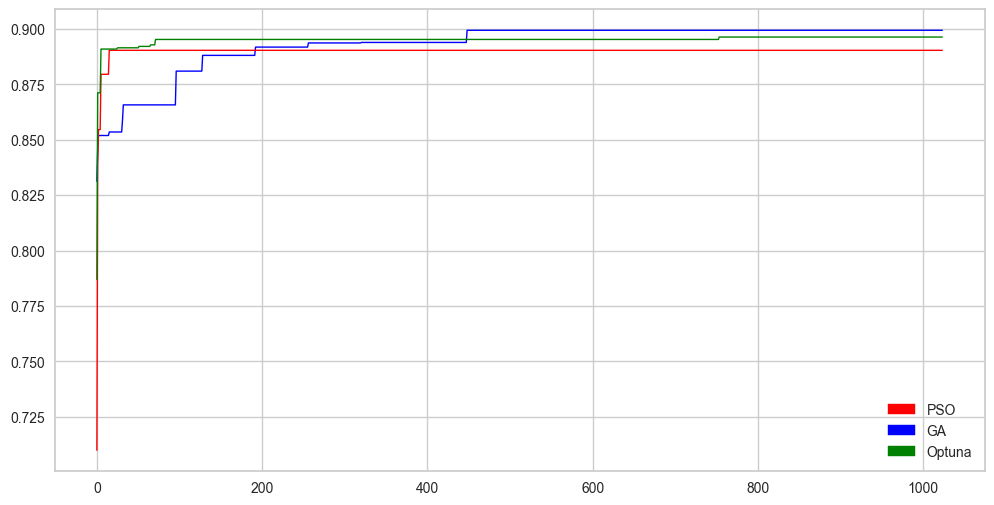

In [ ]:
plt.figure(figsize=(12, 6))
red_patch = mpatches.Patch(color='red', label='PSO')
blue_patch = mpatches.Patch(color='blue', label='GA')
green_patch = mpatches.Patch(color='green', label='Optuna')
#black_patch = mpatches.Patch(color='black', label='GridSearch')

plt.legend(handles=[red_patch, blue_patch, green_patch])
plt.plot(F1_GA, color = 'blue', linewidth=1, linestyle='-', )
plt.plot(F1_PSO, color = 'red', linewidth=1, linestyle='-')
plt.plot(tracking_Optuna_F1, color = 'green', linewidth=1, linestyle='-')
#plt.plot(tracking_GS, color = 'black', linewidth=3, linestyle='-')
plt.show()

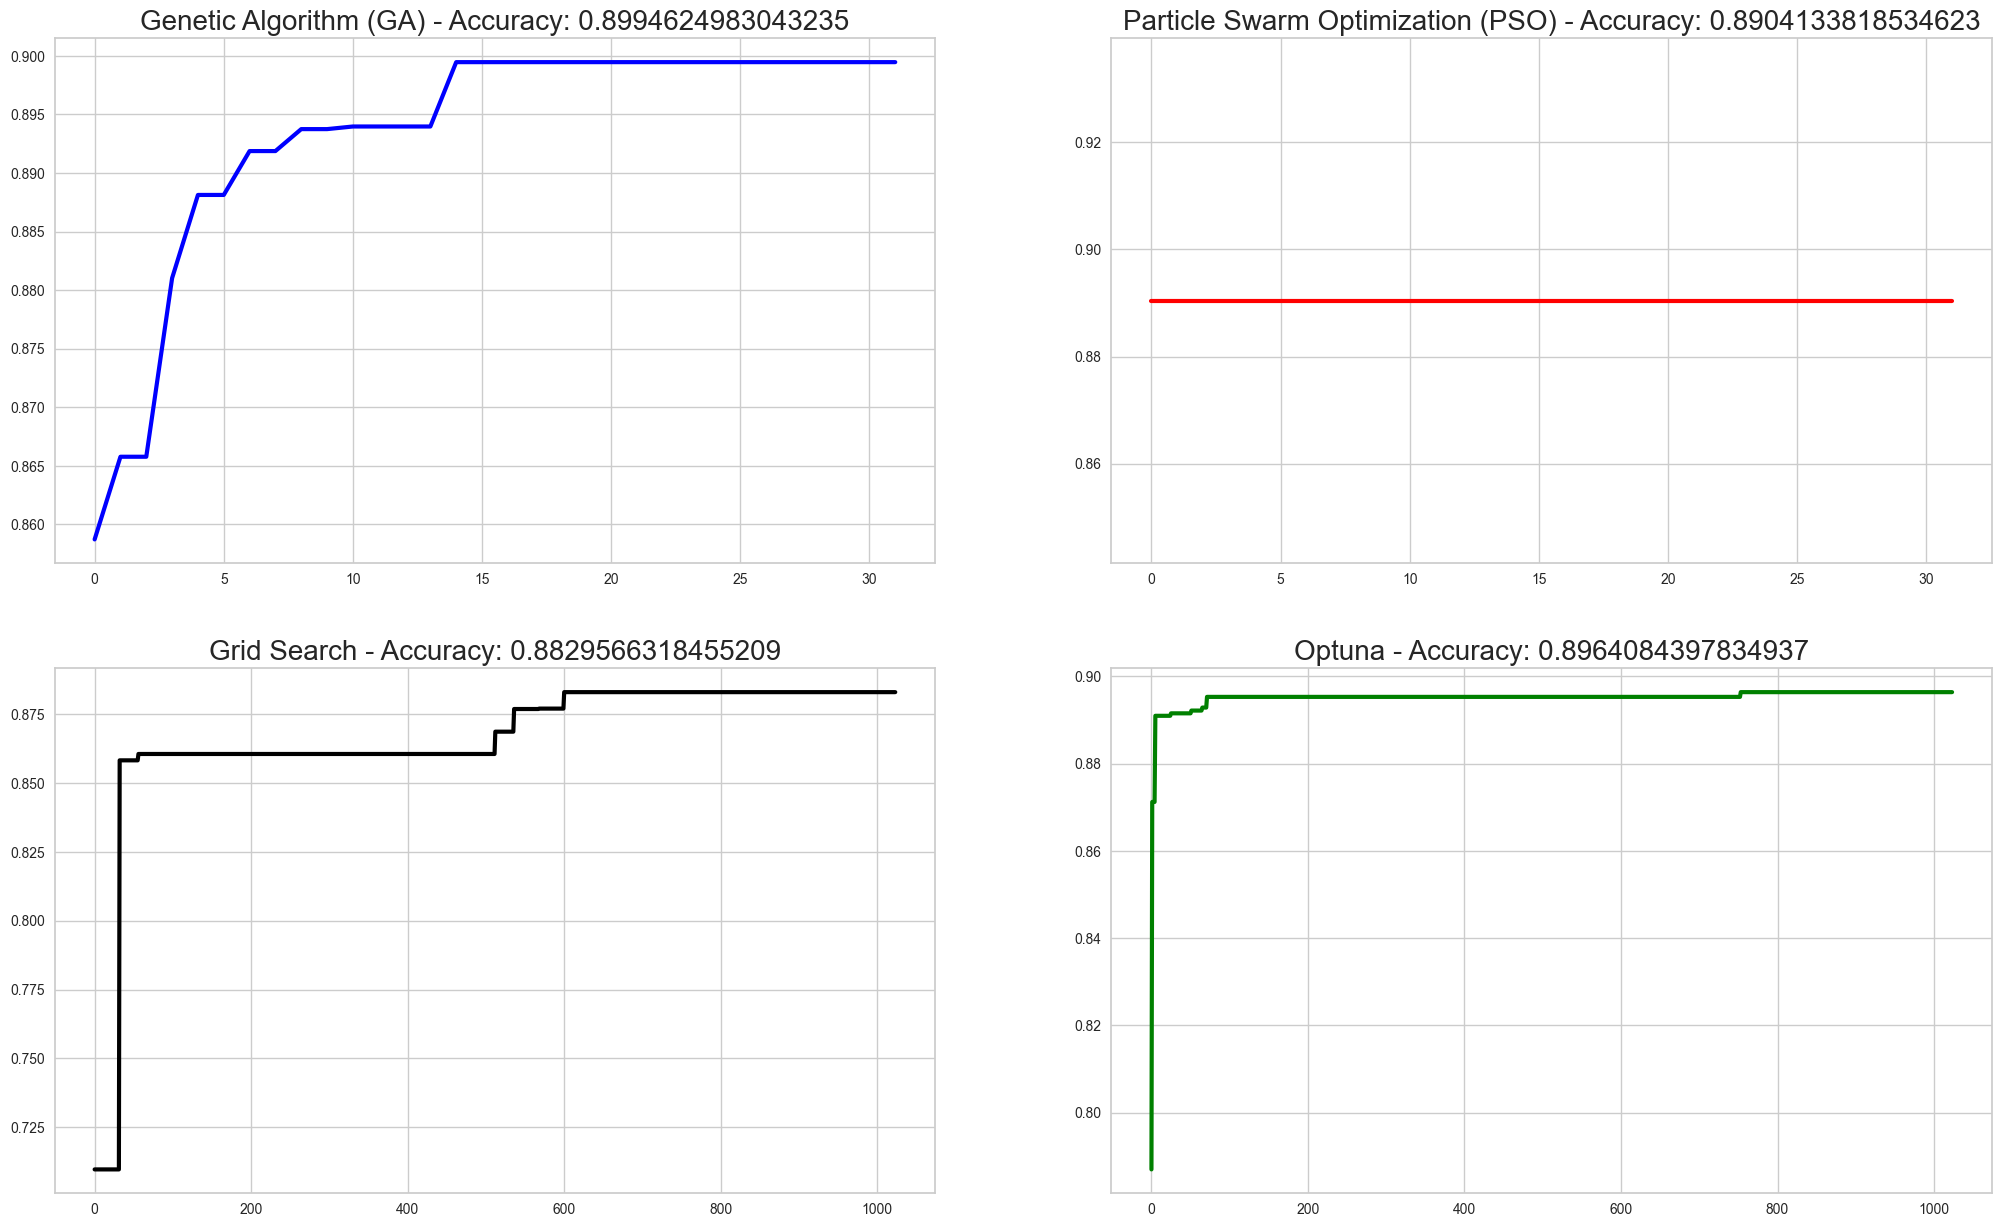

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(25,15))

ax[0, 0].set_title(f'Genetic Algorithm (GA) - Accuracy: {max(tracking_GA_F1)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax[0, 1].set_title(f'Particle Swarm Optimization (PSO) - Accuracy: {max(tracking_PSO_F1)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax[1, 0].set_title(f'Grid Search - Accuracy: {max(tracking_GS_F1)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax[1, 1].set_title(f'Optuna - Accuracy: {max(tracking_Optuna_F1)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax[0,0].plot(tracking_GA_F1, color = 'blue', linewidth=3, linestyle='-', )
ax[0,1].plot(tracking_PSO_F1, color = 'red', linewidth=3, linestyle='-')

ax[1,0].plot(tracking_GS_F1, color = 'black', linewidth=3, linestyle='-')
ax[1,1].plot(tracking_Optuna_F1, color = 'green', linewidth=3, linestyle='-')


ROC AUC

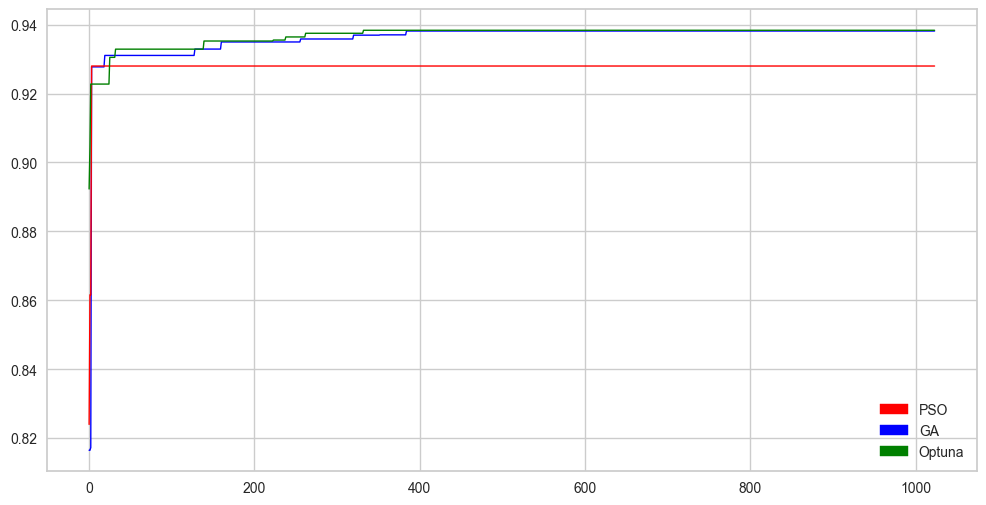

In [ ]:
plt.figure(figsize=(12, 6))
red_patch = mpatches.Patch(color='red', label='PSO')
blue_patch = mpatches.Patch(color='blue', label='GA')
green_patch = mpatches.Patch(color='green', label='Optuna')
#black_patch = mpatches.Patch(color='black', label='GridSearch')

plt.legend(handles=[red_patch, blue_patch, green_patch])
plt.plot(AUC_GA, color = 'blue', linewidth=1, linestyle='-', )
plt.plot(AUC_PSO, color = 'red', linewidth=1, linestyle='-')
plt.plot(tracking_Optuna_AUC, color = 'green', linewidth=1, linestyle='-')
#plt.plot(tracking_GS, color = 'black', linewidth=3, linestyle='-')
plt.show()

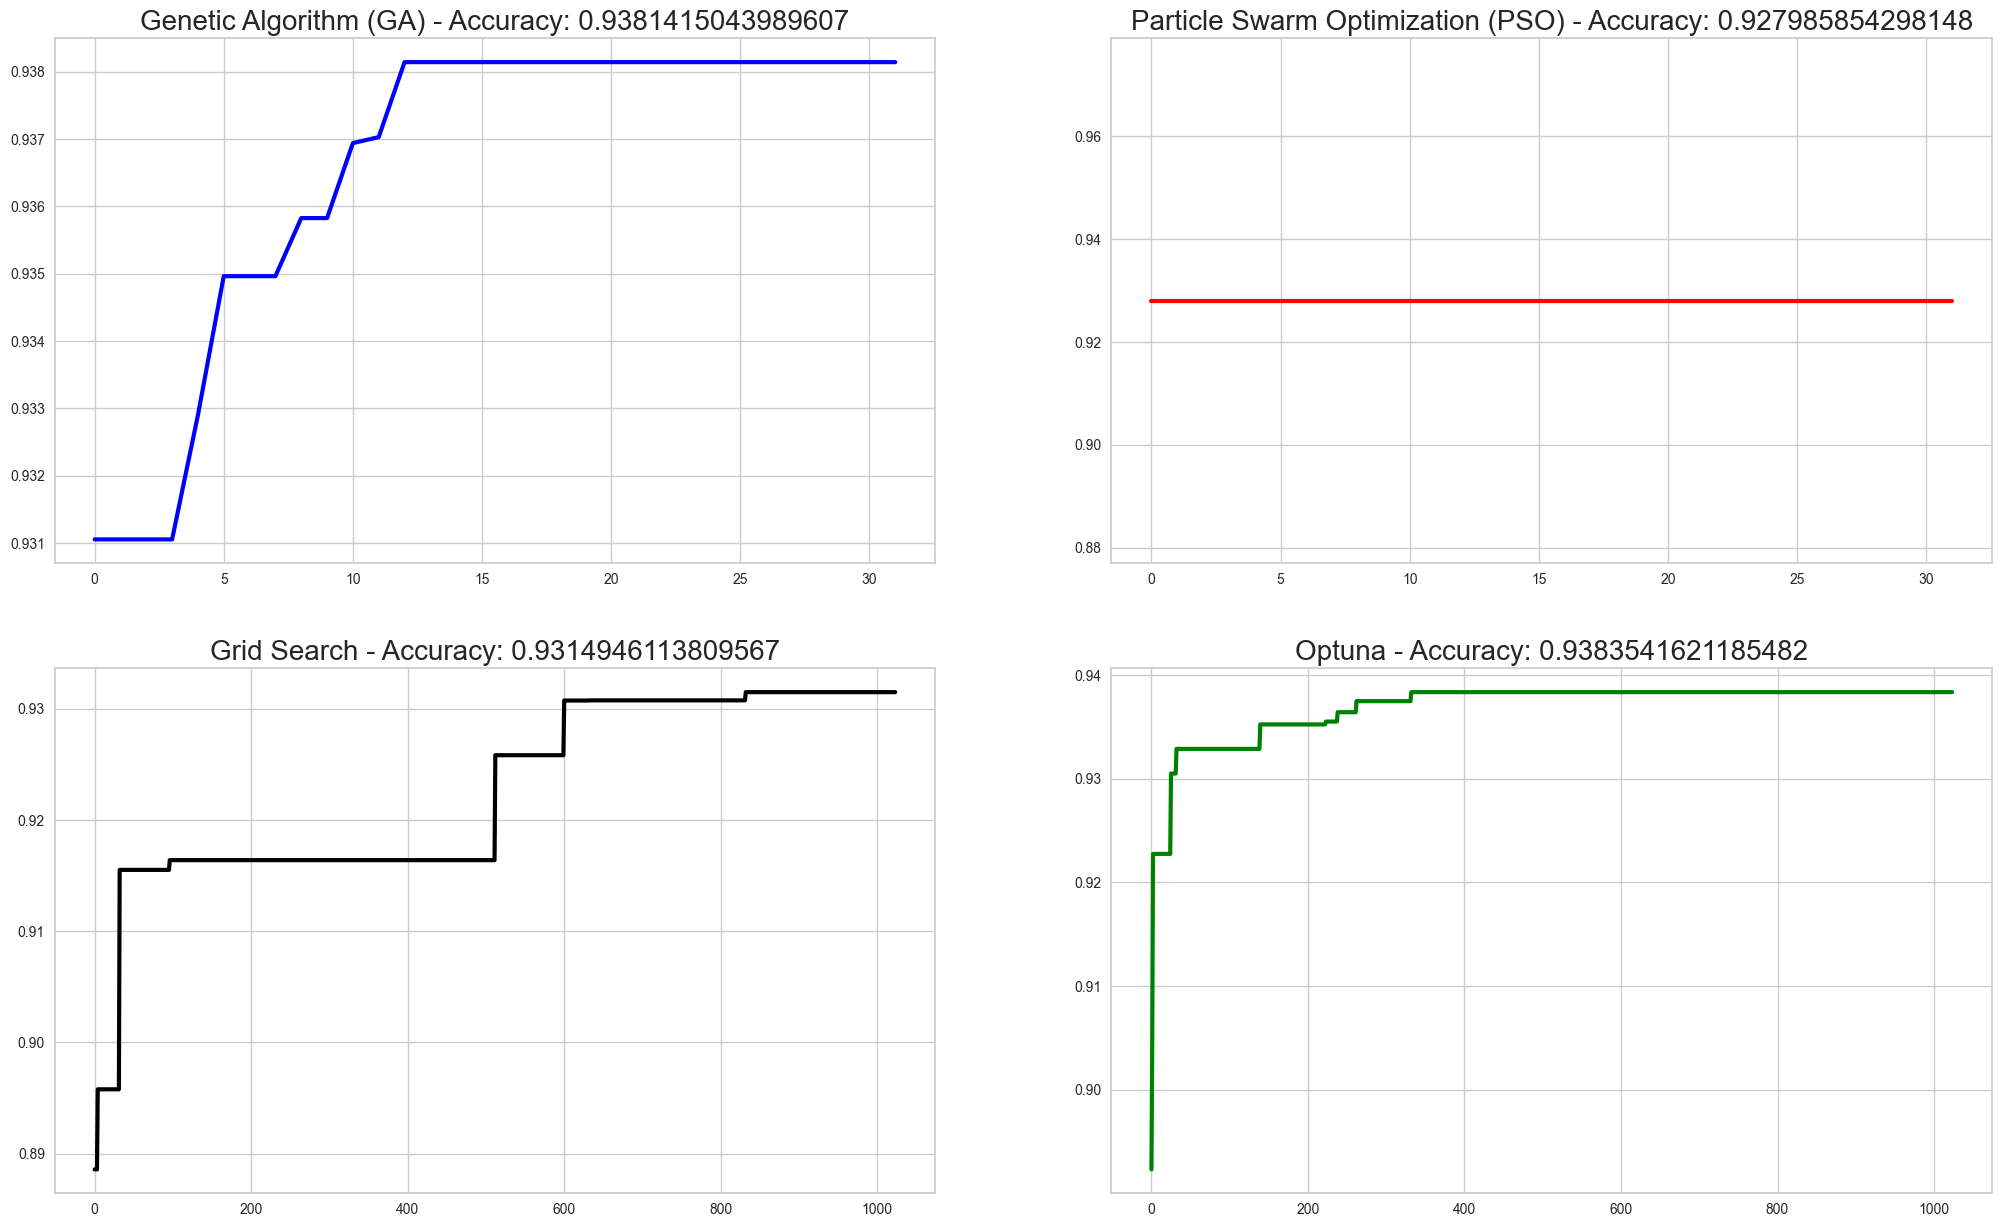

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(25,15))

ax[0, 0].set_title(f'Genetic Algorithm (GA) - Accuracy: {max(tracking_GA_AUC)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax[0, 1].set_title(f'Particle Swarm Optimization (PSO) - Accuracy: {max(tracking_PSO_AUC)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax[1, 0].set_title(f'Grid Search - Accuracy: {max(tracking_GS_AUC)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax[1, 1].set_title(f'Optuna - Accuracy: {max(tracking_Optuna_AUC)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax[0,0].plot(tracking_GA_AUC, color = 'blue', linewidth=3, linestyle='-', )
ax[0,1].plot(tracking_PSO_AUC, color = 'red', linewidth=3, linestyle='-')

ax[1,0].plot(tracking_GS_AUC, color = 'black', linewidth=3, linestyle='-')
ax[1,1].plot(tracking_Optuna_AUC, color = 'green', linewidth=3, linestyle='-')


# Gerando Dados Para Análise 

In [ ]:
from tqdm import tqdm
import pandas as pd
from os import system

filename = './lightGBM_heart_data.csv'

try:
    lightGBM_data = pd.read_csv(filename)
except:
    open(filename, "a")
    lightGBM_data = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'F1', 'AUC'])


for i in tqdm(range(2)):
    accuracy_pso, _, _ = run_accuracy_pso(ITERATIONS=1, POPULATION=1)
    f1_pso, _, _ = run_f1_pso(ITERATIONS=1, POPULATION=1)
    auc_pso, _, _ = run_auc_pso(ITERATIONS=1, POPULATION=1)
    temp = pd.DataFrame({'Algorithm' : ['PSO'], 
                         'Accuracy' :[-accuracy_pso[0]], 
                         'F1' : [-f1_pso[0]], 
                         'AUC' : [-auc_pso[0]]})
    lightGBM_data = lightGBM_data.append(temp, ignore_index = True)
    lightGBM_data[['Algorithm', 'Accuracy', 'F1', 'AUC']].to_csv(filename)
    
    accuracy_ga, _, _ = run_accuracy_ga(ITERATIONS=1, POPULATION=1)
    f1_ga, _, _ = run_f1_ga(ITERATIONS=1, POPULATION=1)
    auc_ga, _, _ = run_auc_ga(ITERATIONS=1, POPULATION=1)
    temp = pd.DataFrame({'Algorithm' : ['GA'], 
                         'Accuracy' :[-accuracy_ga[0]], 
                         'F1' : [-f1_ga[0]], 
                         'AUC' : [-auc_ga[0]]})
    lightGBM_data = lightGBM_data.append(temp, ignore_index = True)
    lightGBM_data[['Algorithm', 'Accuracy', 'F1', 'AUC']].to_csv(filename)
    
    accuracy_optuna, _ = run_optuna_accuracy(n_trials=1)
    f1_optuna, _ = run_optuna_f1(n_trials=1)
    auc_optuna, _ = run_optuna_auc(n_trials=1)
    temp = pd.DataFrame({'Algorithm' : ['Optuna'], 
                         'Accuracy' :[accuracy_optuna], 
                         'F1' : [f1_optuna], 
                         'AUC' : [auc_optuna]})
    lightGBM_data = lightGBM_data.append(temp, ignore_index = True)
    lightGBM_data[['Algorithm', 'Accuracy', 'F1', 'AUC']].to_csv(filename)

  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\Felps\AppData\Local\Temp\ipykernel_25136\595829878.py:8: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


Best Accuracy Score [0.55027025]
Model parameters: 
 [1.84306022e+02 3.54253960e+01 6.05940281e+02 3.86035787e-01
 2.07067081e+05 1.73111813e-01 4.40555524e-02 9.01971834e+01
 6.74774981e+01]



  0%|          | 0/32 [00:01<?, ?it/s]


Best F1 Score [0.85025972]
Model parameters: 
 [5.51814589e+01 2.39494695e+01 3.37959905e+02 2.97212022e-01
 4.01003671e+05 1.08461894e-01 9.03052686e-02 2.06136561e+01
 6.48377059e+01]


  0%|          | 0/32 [00:00<?, ?it/s]
C:\Users\Felps\AppData\Local\Temp\ipykernel_25136\2494104936.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lightGBM_data = lightGBM_data.append(temp, ignore_index = True)
C:\Users\Felps\AppData\Local\Temp\ipykernel_25136\2052111469.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


Best AUC Score [0.81281812]
Model parameters: 
 [1.78737669e+02 2.28203471e+01 5.96919628e+02 2.26083641e-01
 4.62271443e+05 4.02349854e-01 9.07193978e-02 7.93419519e+01
 4.44708161e+01]



  0%|          | 0/32 [00:00<?, ?it/s]


Best Accuracy Score [0.82542372]
Model parameters: 
 [1.45598463e+02 4.95043102e+01 5.46839253e+02 9.45386425e-02
 1.24577125e+05 7.87979229e-02 9.36445725e-02 2.77327991e+01
 9.10305822e+01]


  0%|          | 0/32 [00:00<?, ?it/s]


Best F1 Score [0.83320852]
Model parameters: 
 [8.26668783e+01 1.89810827e+01 8.26913977e+02 5.59293627e-02
 3.83925506e+05 3.78129295e-01 1.45365865e-01 4.56912354e+01
 2.94876918e+01]



  0%|          | 0/32 [00:00<?, ?it/s]
C:\Users\Felps\AppData\Local\Temp\ipykernel_25136\2494104936.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lightGBM_data = lightGBM_data.append(temp, ignore_index = True)
C:\Users\Felps\AppData\Local\Temp\ipykernel_25136\2494104936.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lightGBM_data = lightGBM_data.append(temp, ignore_index = True)
 50%|█████     | 1/2 [00:04<00:04,  4.94s/it]C:\Users\Felps\AppData\Local\Temp\ipykernel_25136\595829878.py:8: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


Best AUC Score [0.81313762]
Model parameters: 
 [1.02770351e+02 4.52819185e+01 7.43074884e+02 1.15713764e-01
 1.12436214e+05 4.80749643e-01 1.42663300e-01 8.24407088e+01
 5.66277006e+01]
Accuracy: 0.8165753595447112
Best hyperparameters: {'num_leaves': 59, 'min_child_samples': 40, 'n_estimators': 860, 'learning_rate': 0.17810832351181038, 'subsample_for_bin': 145996, 'min_split_gain': 0.47286903046933837, 'min_child_weight': 0.01007189636129753, 'reg_alpha': 48.46303020156848, 'reg_lambda': 88.7321528643025}
F1: 0.7097031579005014
Best hyperparameters: {'num_leaves': 115, 'min_child_samples': 23, 'n_estimators': 54, 'learning_rate': 0.06992072495577288, 'subsample_for_bin': 137450, 'min_split_gain': 0.18941623912143396, 'min_child_weight': 0.07740844493939339, 'reg_alpha': 85.78631282740508, 'reg_lambda': 52.54688029148316}
AUC: 0.926075106956819
Best hyperparameters: {'num_leaves': 192, 'min_child_samples': 12, 'n_estimators': 529, 'learning_rate': 0.4118940364341363, 'subsample_for_b

  0%|          | 0/32 [00:00<?, ?it/s]


Best Accuracy Score [0.71279693]
Model parameters: 
 [1.27017834e+02 2.75151460e+01 4.03325125e+01 1.87436064e-01
 4.40720261e+05 4.16710499e-01 3.09764640e-02 6.87154531e+01
 6.44102103e+01]



  0%|          | 0/32 [00:00<?, ?it/s]


Best F1 Score [0.83649805]
Model parameters: 
 [7.53650582e+01 4.97820547e+01 7.07561923e+02 1.10882341e-01
 3.04309813e+05 6.37659083e-02 6.17549548e-02 5.43628562e+01
 2.39117060e+01]


  0%|          | 0/32 [00:00<?, ?it/s]
C:\Users\Felps\AppData\Local\Temp\ipykernel_25136\2494104936.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lightGBM_data = lightGBM_data.append(temp, ignore_index = True)
C:\Users\Felps\AppData\Local\Temp\ipykernel_25136\2052111469.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


Best AUC Score [0.90466272]
Model parameters: 
 [1.52594306e+02 4.89886597e+01 2.91045607e+02 3.53953257e-01
 3.08082253e+05 2.26482443e-01 8.25871100e-02 2.33505056e+01
 2.48011224e+01]



  0%|          | 0/32 [00:00<?, ?it/s]


Best Accuracy Score [0.84417651]
Model parameters: 
 [1.30232793e+02 1.99612203e+01 3.72958794e+02 1.40405556e-01
 2.64390706e+05 1.33203771e-01 4.28879355e-02 1.92501114e+01
 3.39727842e+01]


  0%|          | 0/32 [00:00<?, ?it/s]


Best F1 Score [0.85056507]
Model parameters: 
 [3.92541709e+01 4.71393549e+01 5.97967009e+02 2.63023743e-01
 1.27263291e+05 4.22438712e-01 7.50317050e-02 1.19605877e+01
 7.89152769e+01]



  0%|          | 0/32 [00:00<?, ?it/s]

Best AUC Score [0.89993722]
Model parameters: 
 [1.37380378e+02 4.64043464e+01 2.57897579e+01 4.69554403e-01
 2.87608511e+05 2.39206414e-01 1.05620960e-01 2.82340753e+01
 5.85961217e+01]
Accuracy: 0.816590027355467
Best hyperparameters: {'num_leaves': 135, 'min_child_samples': 21, 'n_estimators': 655, 'learning_rate': 0.25926571811154775, 'subsample_for_bin': 157007, 'min_split_gain': 0.344115484862961, 'min_child_weight': 0.054910338349634366, 'reg_alpha': 67.70876789709757, 'reg_lambda': 4.742502563826816}
F1: 0.7094902663232862
Best hyperparameters: {'num_leaves': 22, 'min_child_samples': 47, 'n_estimators': 381, 'learning_rate': 0.31483130499939194, 'subsample_for_bin': 141826, 'min_split_gain': 0.393473112932172, 'min_child_weight': 0.009527030066978515, 'reg_alpha': 89.71774018867004, 'reg_lambda': 73.03870369041837}



C:\Users\Felps\AppData\Local\Temp\ipykernel_25136\2494104936.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lightGBM_data = lightGBM_data.append(temp, ignore_index = True)
C:\Users\Felps\AppData\Local\Temp\ipykernel_25136\2494104936.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lightGBM_data = lightGBM_data.append(temp, ignore_index = True)
100%|██████████| 2/2 [00:05<00:00,  2.56s/it]

AUC: 0.814409097614811
Best hyperparameters: {'num_leaves': 40, 'min_child_samples': 36, 'n_estimators': 676, 'learning_rate': 0.1998466770461583, 'subsample_for_bin': 133121, 'min_split_gain': 0.24666451964416705, 'min_child_weight': 0.10940975334964409, 'reg_alpha': 77.26589677304815, 'reg_lambda': 28.872889684928175}


In [ ]:
lightGBM_data.to_csv(filename)